# Model selection for DGA-Detector

In [1]:
import pyarrow as pa
import pyarrow.parquet as pq

dga = pq.read_table("floor/02-Preprocessed-data/DGA/01-DGA-Features.parquet")
benign = pq.read_table(
    "floor/02-Preprocessed-data/Benign/00-Benign-Features.parquet")

# realign schemas (parquet files save in nonsense orders)
benign = benign.cast(dga.schema)

dga = dga.append_column("label", pa.array(["dga"] * len(dga)))
benign = benign.append_column("label", pa.array(["benign"] * len(benign)))

dga = dga.drop(["domain_name"])
benign = benign.drop(["domain_name"])

# concatentate tables
data = pa.concat_tables([dga, benign])
df = data.to_pandas()

# Handle NaNs
df.fillna(-1, inplace=True)

df

,lex_name_len,lex_has_digit,lex_phishing_keyword_count,lex_consecutive_chars,lex_tld_len,lex_tld_abuse_score,lex_sld_len,lex_sld_norm_entropy,lex_sld_digit_count,lex_sld_digit_ratio,...,mod_jaccard_tri-grams_benign,mod_jaccard_penta-grams_benign,mod_jaccard_bi-grams_dga,mod_jaccard_tri-grams_dga,mod_jaccard_penta-grams_dga,lex_avg_part_len,lex_stdev_part_lens,lex_longest_part_len,lex_shortest_sub_len,label
0,15,0,0,2,2,0.0000,12,0.237949,0.0,0.000000,...,0.538462,0.000000,0.857143,0.076923,0.000000,7.000000,0.500000,12,12,dga
1,31,1,0,2,3,0.0081,27,0.151053,9.0,0.333333,...,0.172414,0.000000,0.900000,0.137931,0.074074,15.000000,0.500000,27,27,dga
2,19,0,0,1,3,0.6554,15,0.221549,0.0,0.000000,...,0.411765,0.133333,0.888889,0.529412,0.000000,9.000000,0.500000,15,15,dga
3,13,0,1,1,4,0.0043,8,0.375000,0.0,0.000000,...,0.454545,0.222222,0.833333,0.272727,0.111111,6.000000,0.500000,8,8,dga
4,30,1,0,1,3,0.0081,26,0.165993,8.0,0.307692,...,0.142857,0.000000,0.689655,0.107143,0.000000,14.500000,0.500000,26,26,dga
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
691813,15,0,0,2,10,0.0000,4,0.375000,0.0,0.000000,...,0.615385,0.454545,0.714286,0.076923,0.000000,4.333333,0.528321,7,4,benign
691814,30,0,0,2,5,0.0000,8,0.343750,0.0,0.000000,...,0.714286,0.307692,0.862069,0.285714,0.000000,9.333333,0.528321,15,23,benign
691815,9,0,0,2,2,0.0000,6,0.375272,0.0,0.000000,...,0.571429,0.000000,0.750000,0.142857,0.000000,4.000000,0.500000,6,6,benign
691816,7,0,0,3,3,0.0000,3,0.000000,0.0,0.000000,...,0.400000,0.000000,0.800000,0.000000,0.000000,3.000000,0.000000,3,3,benign


## Subsampling the dataset

In [2]:
subsample = 1  # 1.0 means no subsample

if subsample < 1.0:
    df = df.sample(frac=subsample)

## Supressing unwanted warnings

In [3]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.*")
warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost.*")
warnings.filterwarnings(
    "ignore", message="Series.__getitem__ treating keys as positions is deprecated.*"
)
warnings.filterwarnings("ignore", category=FutureWarning)

# Train-Test Split

In [4]:
from sklearn.model_selection import train_test_split

class_map = {"benign": 0, "dga": 1}

labels = df["label"].apply(lambda x: class_map[x])  # y vector
features = df.drop("label", axis=1).copy()  # X matrix

X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.3, random_state=42, shuffle=True, stratify=labels
)

# Generate seeds

In [5]:
import random


def generate_random_seeds(
    base_seed=None, count=1, lower_bound=0, upper_bound=65535, deterministic=False
):
    """
    Generate a list of pseudorandom seeds.

    Parameters:
        base_seed (int, optional): Seed for the random number generator to ensure repeatability. Default is None.
        count (int): Number of random seeds to generate. Must be positive.
        lower_bound (int): Lower bound of the random number range. Default is 0.
        upper_bound (int): Upper bound of the random number range. Default is 65535.
        deterministic (bool): If True, use a deterministic pseudo-random generator; otherwise, use the system's random source. Default is False.

    Returns:
        list of int: A list containing the generated random seeds.

    Raises:
        ValueError: If `count`, `lower_bound`, or `upper_bound` are not correctly specified.
    """
    if count < 1:
        raise ValueError("Count must be at least 1")
    if lower_bound >= upper_bound:
        raise ValueError("Lower bound must be less than upper bound")

    random_generator = random.Random()
    if base_seed is not None:
        random_generator.seed(base_seed)
    elif deterministic:
        random_generator.seed(
            "fixed_seed"
        )  # Use a fixed seed if deterministic without a specific base_seed

    seeds = [random_generator.randint(lower_bound, upper_bound) for _ in range(count)]
    return seeds


# Graph functions

In [6]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


def plot_confusion_matrix(y_true, y_pred, classes):
    """
    This function plots the confusion matrix using Seaborn with updated class labels and a blue colormap.
    :param y_true: array-like of shape (n_samples,), True labels.
    :param y_pred: array-like of shape (n_samples,), Predicted labels.
    :param classes: list, Class labels to display on the axes.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.set_theme(style="white")

    cmap = sns.color_palette("Blues")

    sns.heatmap(
        cm,
        annot=True,
        cmap=cmap,
        cbar=True,
        xticklabels=classes,
        yticklabels=classes,
        fmt="d",
    )
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

    plt.xticks(rotation=0)
    plt.yticks(rotation=90)

    plt.show()

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from scipy.interpolate import interp1d


def plot_roc_curve(
    y_true,
    y_probs,
    title="Receiver Operating Characteristic",
    classifier_label="Classifier",
):
    """
    This function plots the ROC curve.
    :param y_true: array-like of shape (n_samples,), True labels.
    :param y_probs: array-like of shape (n_samples,), Probability estimates of the positive class.
    :param title: str, Title of the graph.
    :param classifier_label: str, Label to describe the classifier.
    """
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)

    # Interpolating the ROC curve points for smoother lines
    fpr_interp = np.linspace(0, 1, 1000)
    tpr_interp = interp1d(fpr, tpr)(fpr_interp)

    plt.figure(figsize=(10, 8))
    sns.set_theme(style="whitegrid")
    plt.plot(
        fpr_interp,
        tpr_interp,
        color="darkorange",
        lw=2,
        label=f"ROC curve ({classifier_label}) (area = {roc_auc:.4f})",
    )
    plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# Initialize results dictionary

In [8]:
results = dict()

In [9]:
SEEDS = generate_random_seeds(count=5)

TypeError: Random.randint() missing 2 required positional arguments: 'a' and 'b'

# Logistic Regression

-----------------------------------
Logistic Regression - Seed: 22867


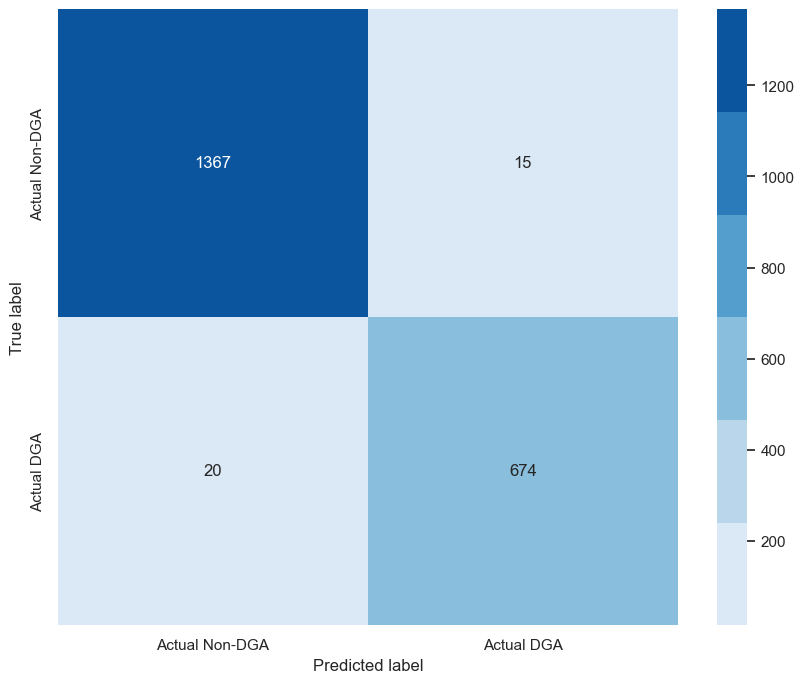

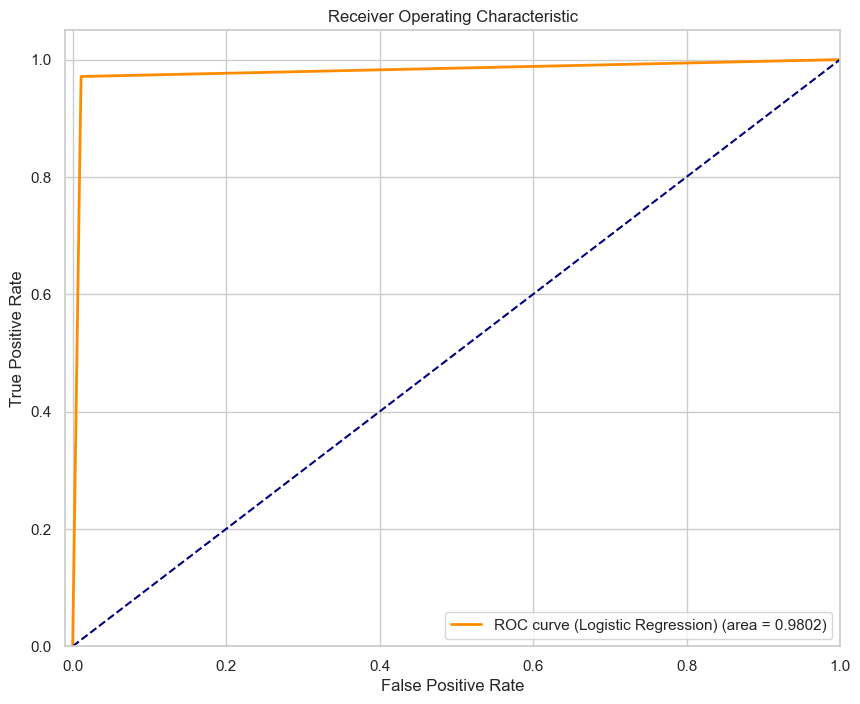

-----------------------------------
Logistic Regression - Seed: 20933


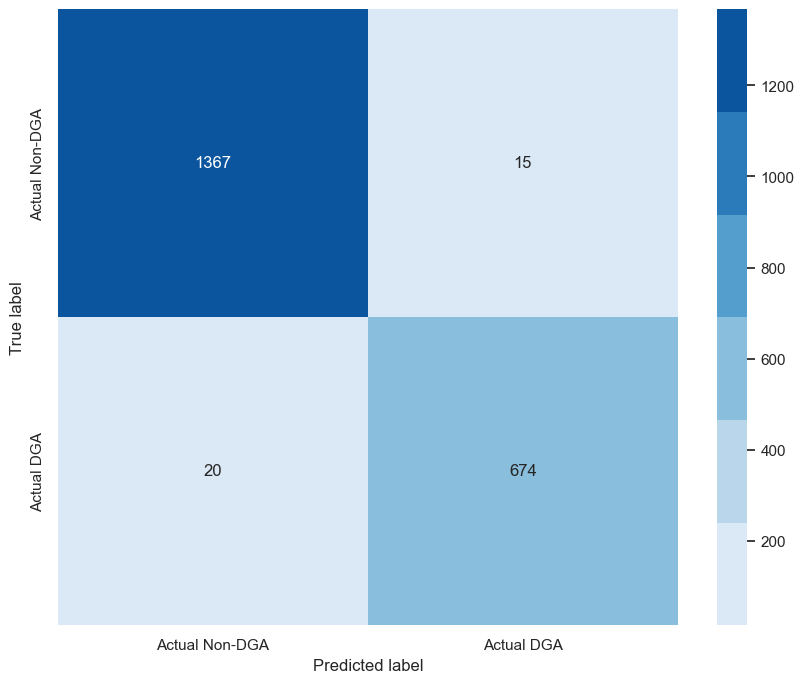

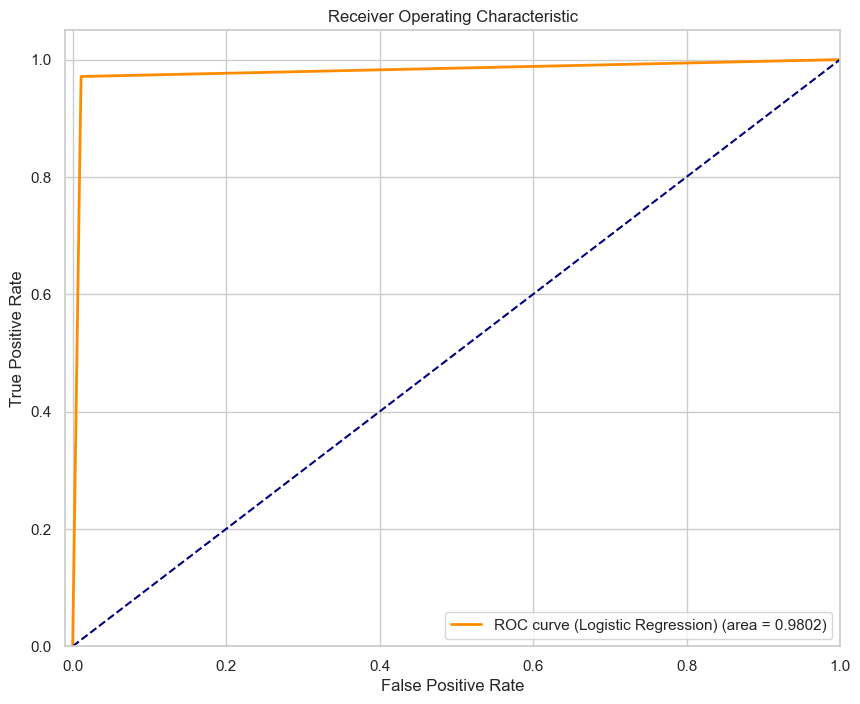

-----------------------------------
Logistic Regression - Seed: 46788


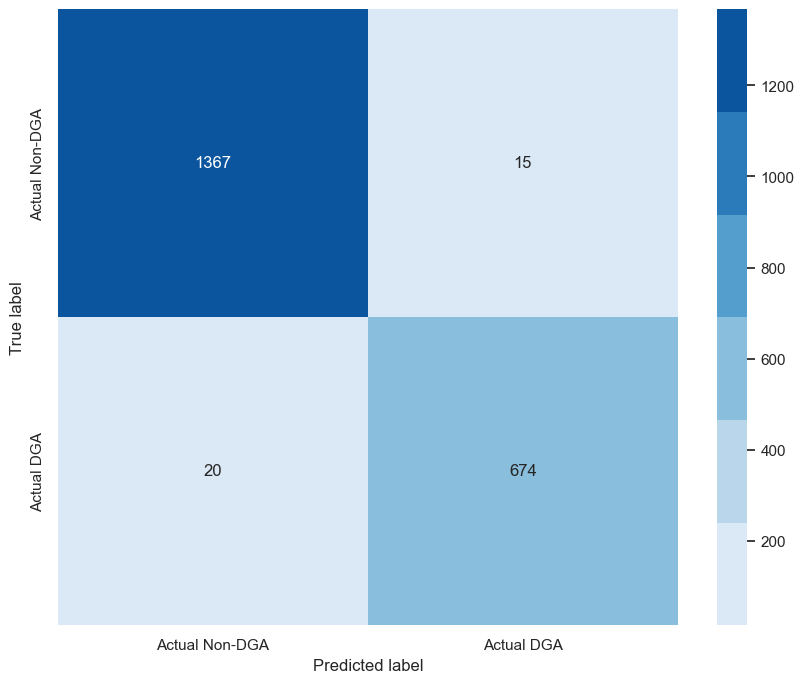

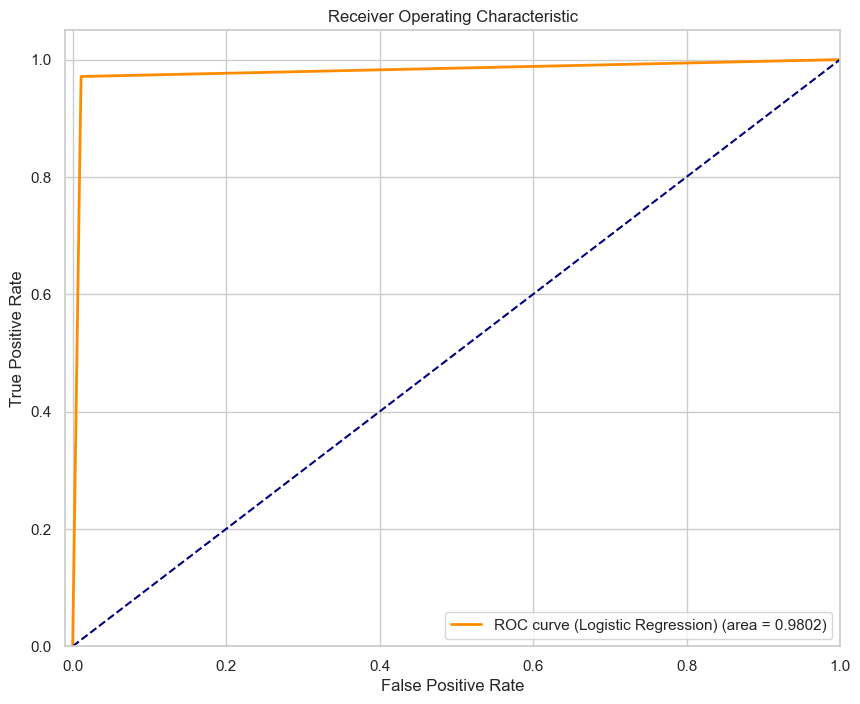

-----------------------------------
Logistic Regression - Seed: 18506


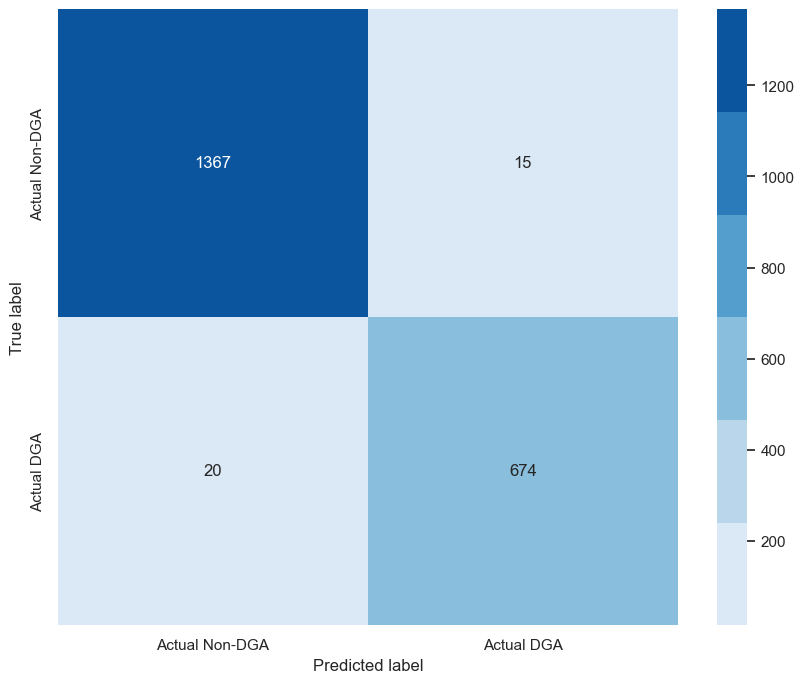

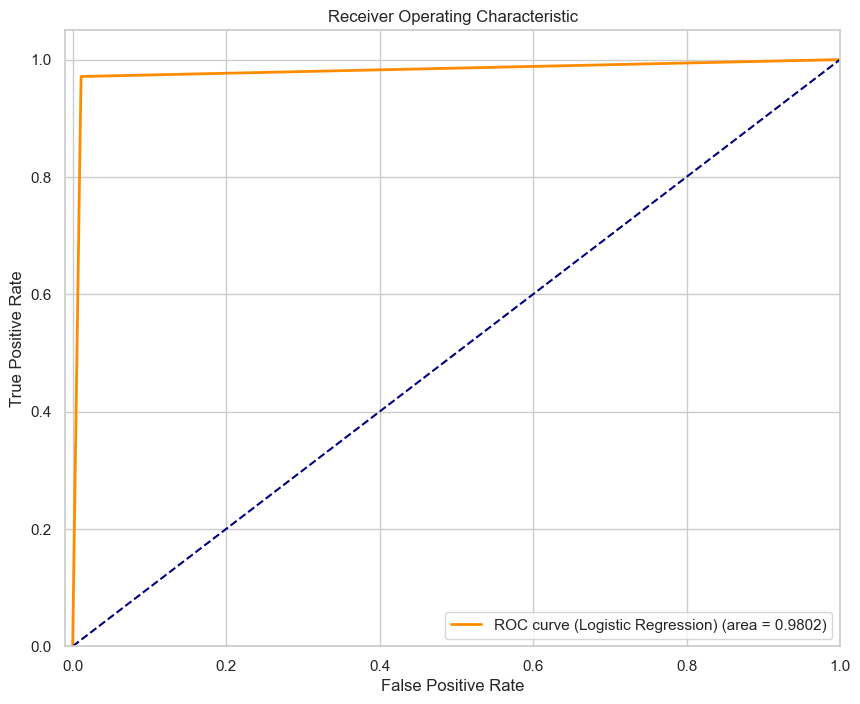

-----------------------------------
Logistic Regression - Seed: 36450


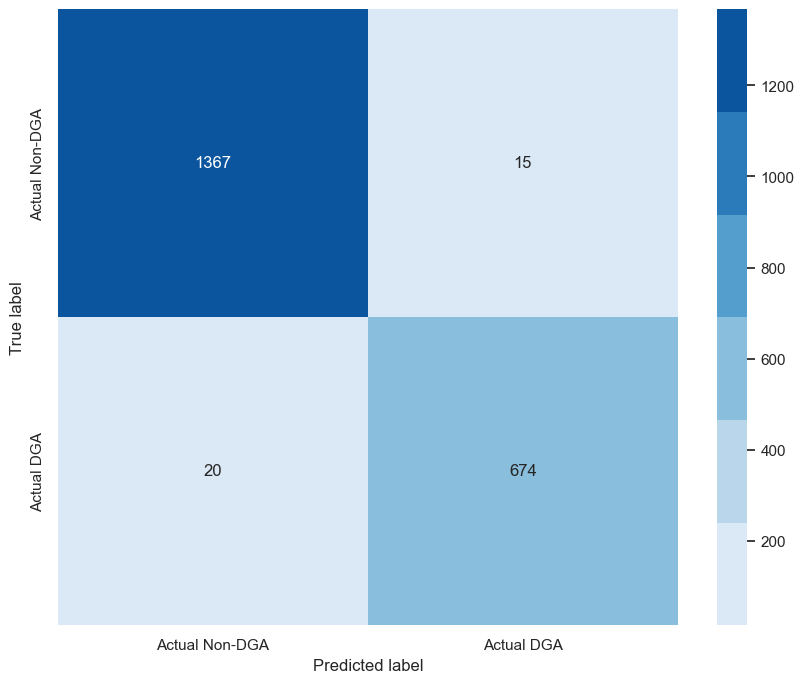

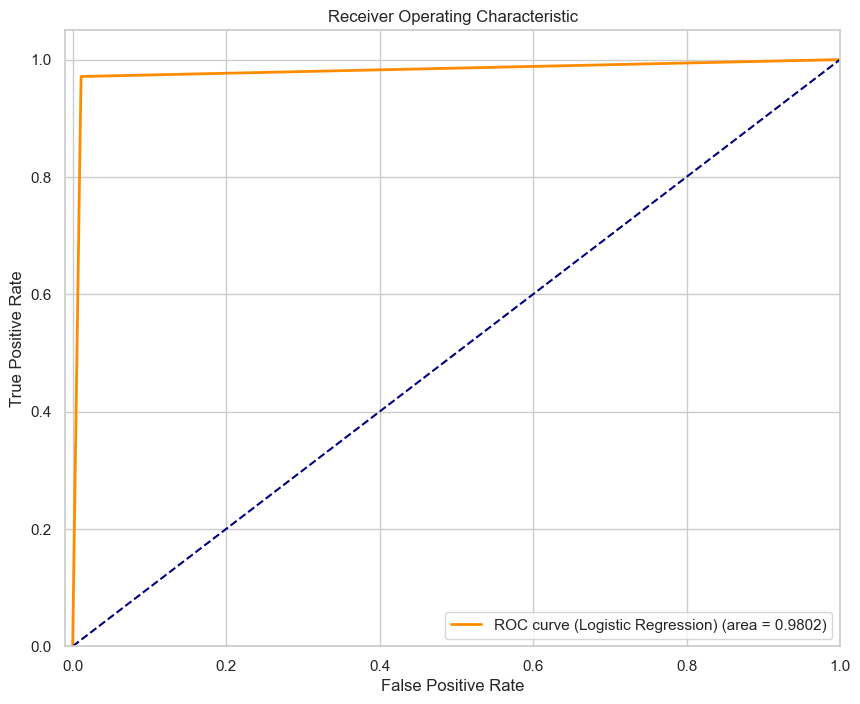

,Accuracy,Precision,Recall,FPR,F1,AUC,Training time,Prediction time
0,0.983141,0.978229,0.971182,0.010854,0.974693,0.980164,5.088170,0.004473
1,0.983141,0.978229,0.971182,0.010854,0.974693,0.980164,4.302904,0.002223
2,0.983141,0.978229,0.971182,0.010854,0.974693,0.980164,2.876713,0.003442
3,0.983141,0.978229,0.971182,0.010854,0.974693,0.980164,5.525143,0.005129
4,0.983141,0.978229,0.971182,0.010854,0.974693,0.980164,2.965734,0.006378


In [10]:
import datetime

import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

# Initialize results dictionary for LR
results["LR"] = {
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "FPR": [],
    "F1": [],
    "AUC": [],
    "Training time": [],
    "Prediction time": [],
}

# Scale the data
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(X_train)
x_test_scaled = scaler.transform(X_test)

params = {
    "C": 100,  # Regularization parameter (default: 1.0)
    "penalty": "l2",  # None, l1, l2 (default), elasticnet (both l1 and l2)
    "max_iter": 100,  # Maximum number of iterations (default: 100)
    "solver": "liblinear",  # lbfgs, liblinear, newton-cg, newton-cholesky, sag, saga
}

for seed in SEEDS:
    print("-----------------------------------")
    print(f"Logistic Regression - Seed: {seed}")
    
    # Shuffle
    lr_x_train, lr_y_train = shuffle(x_train_scaled, y_train, random_state=seed)

    # Create Logistic Regression model
    lr = LogisticRegression(**params, random_state=seed)

    # Measure the training time
    start_time = datetime.datetime.now()
    lr.fit(lr_x_train, lr_y_train)
    end_time = datetime.datetime.now()
    training_time = (end_time - start_time).total_seconds()

    # Measure the prediction time
    start_time = datetime.datetime.now()
    y_pred = lr.predict(x_test_scaled)
    end_time = datetime.datetime.now()
    prediction_time = (end_time - start_time).total_seconds()

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_sc = roc_auc_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fpr = fp / (fp + tn)

    # Store metrics in results dictionary
    results["LR"]["Accuracy"].append(accuracy)
    results["LR"]["Precision"].append(precision)
    results["LR"]["Recall"].append(recall)
    results["LR"]["F1"].append(f1)
    results["LR"]["AUC"].append(auc_sc)
    results["LR"]["FPR"].append(fpr)
    results["LR"]["Training time"].append(training_time)
    results["LR"]["Prediction time"].append(prediction_time)

    # Plot confusion matrix
    plot_confusion_matrix(y_test, y_pred, classes=["Actual Non-DGA", "Actual DGA"])
    
    # Plot ROC curve
    plot_roc_curve(y_test, y_pred, classifier_label="Logistic Regression")

# Print the results in dataframe - well formatted table
results_df = pd.DataFrame(results["LR"])
results_df

# SVM

-----------------------------------
Support Vector Machine - Seed: 22867


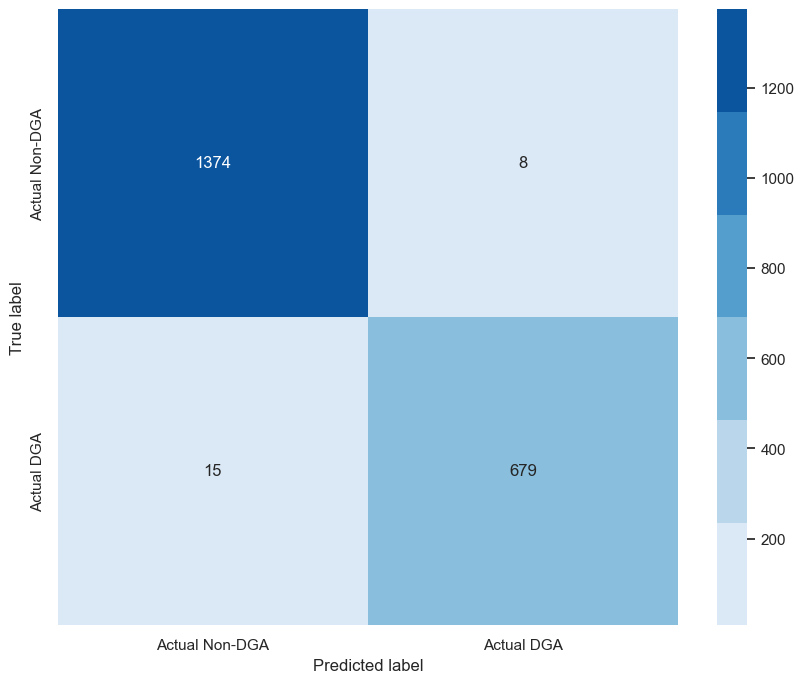

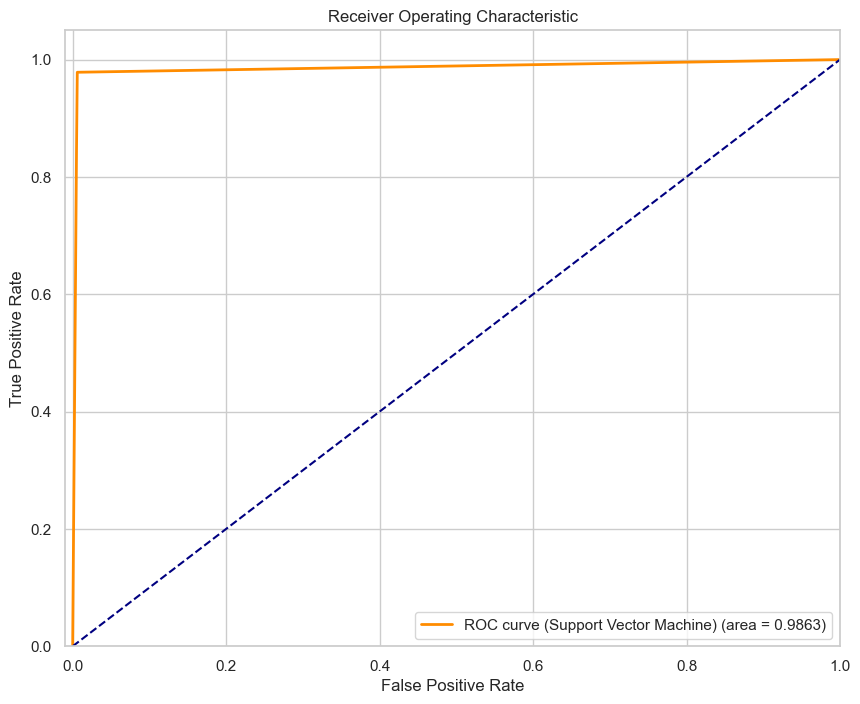

-----------------------------------
Support Vector Machine - Seed: 20933


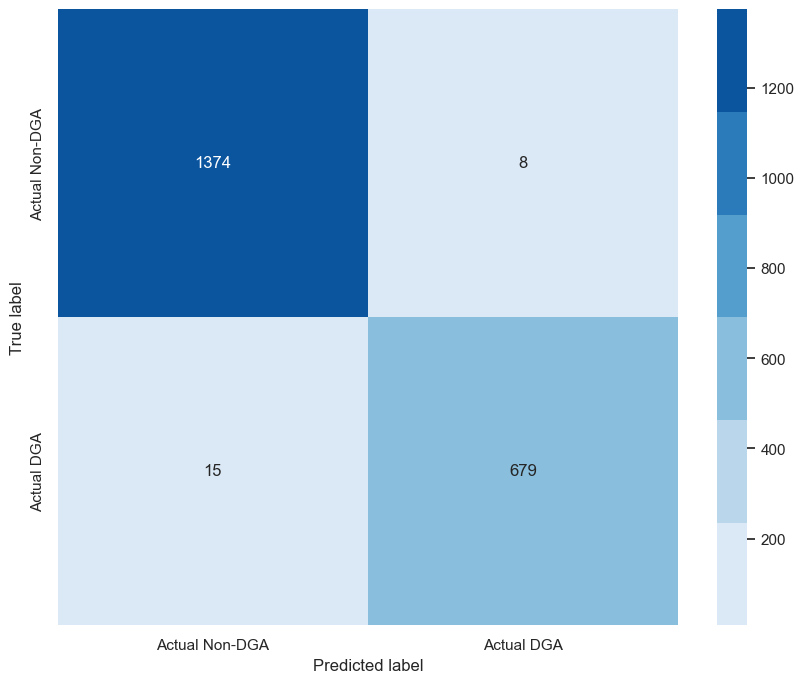

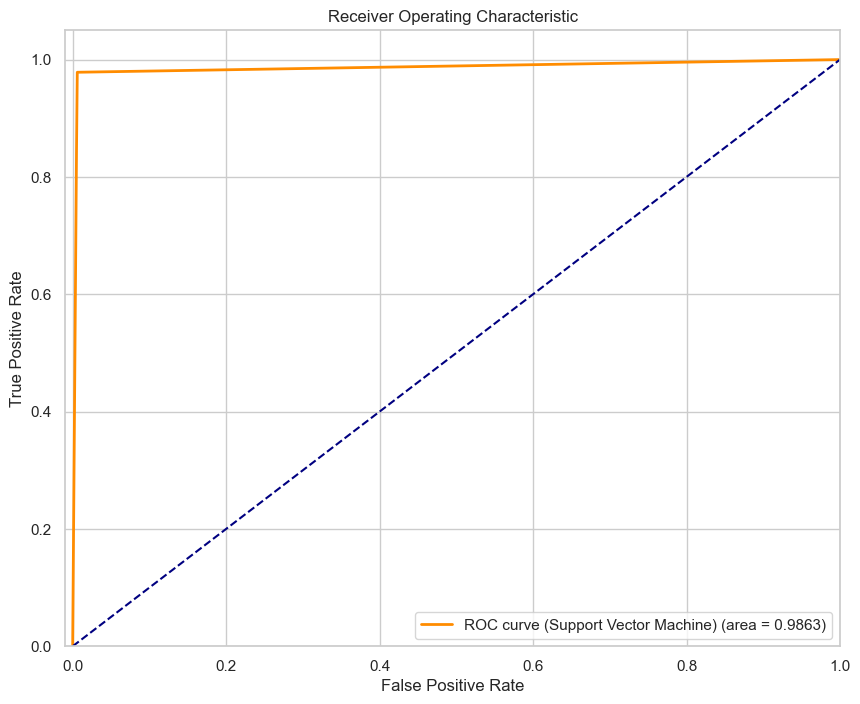

-----------------------------------
Support Vector Machine - Seed: 46788


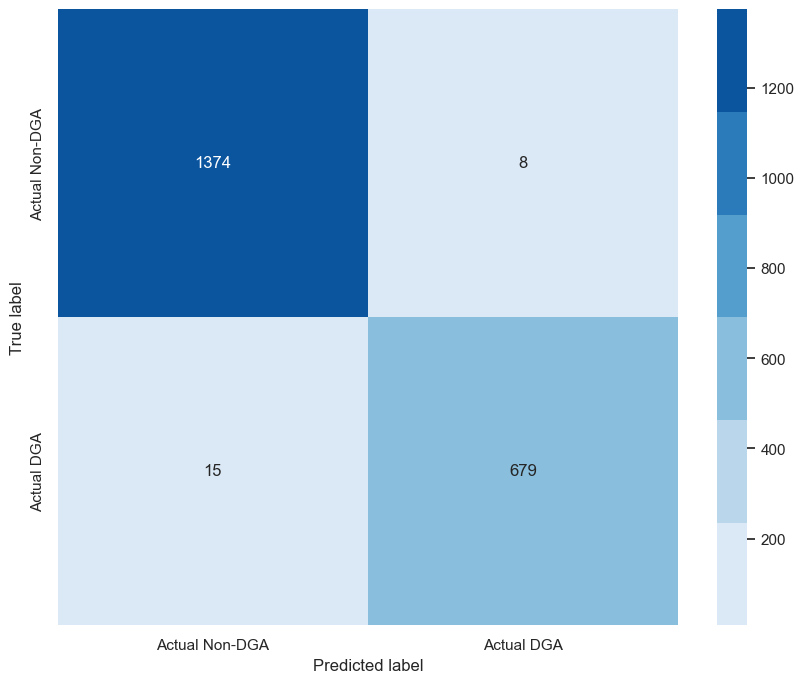

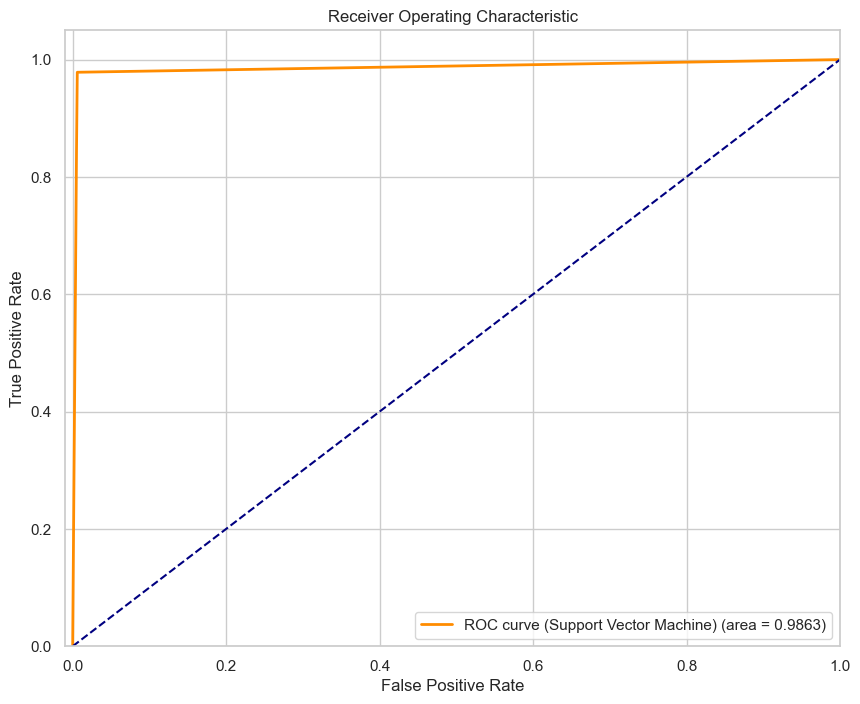

-----------------------------------
Support Vector Machine - Seed: 18506


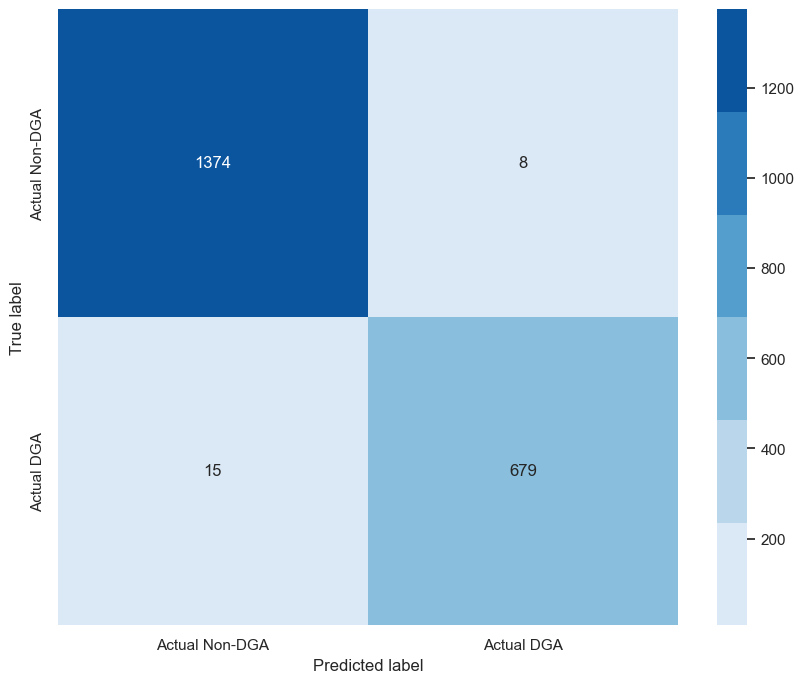

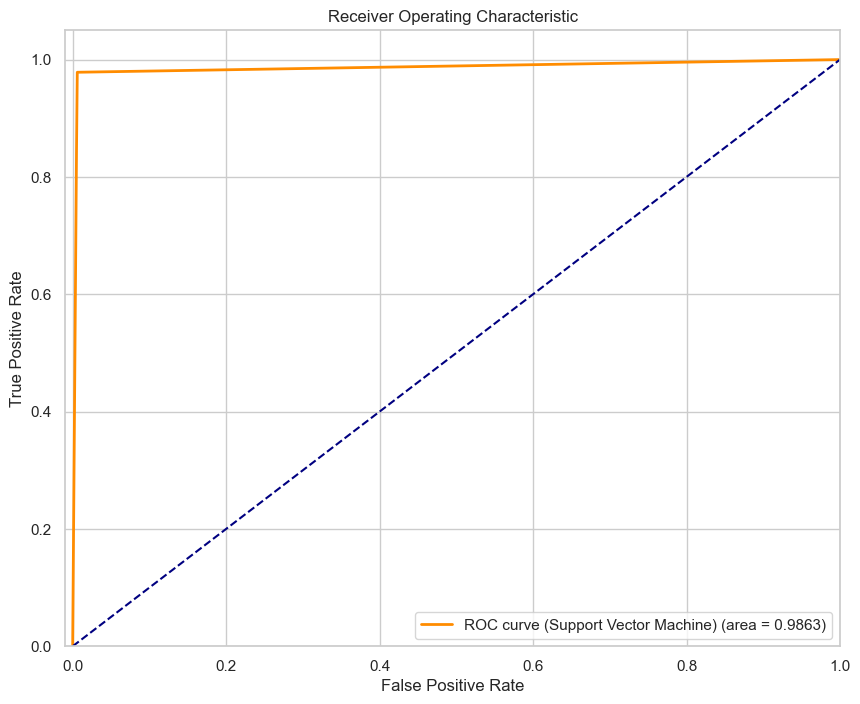

-----------------------------------
Support Vector Machine - Seed: 36450


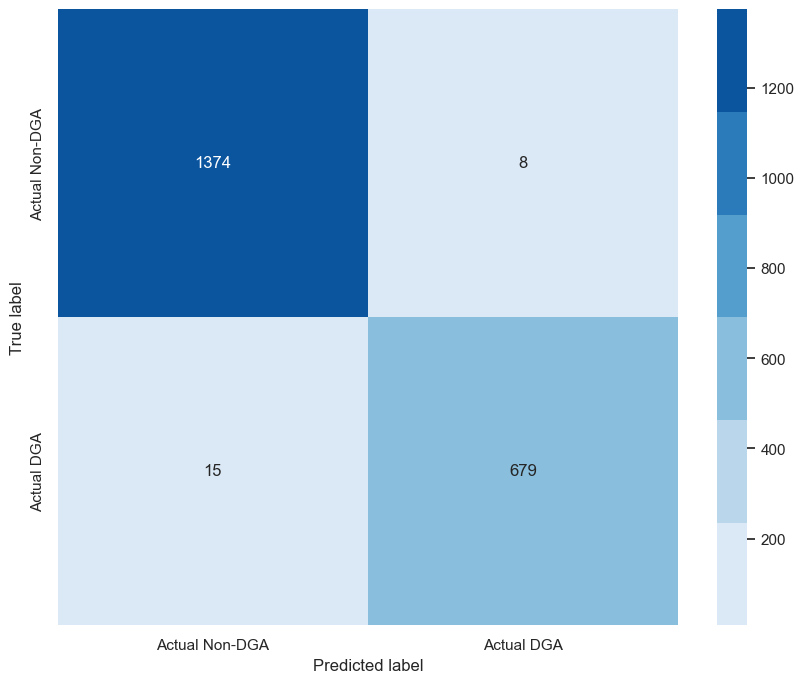

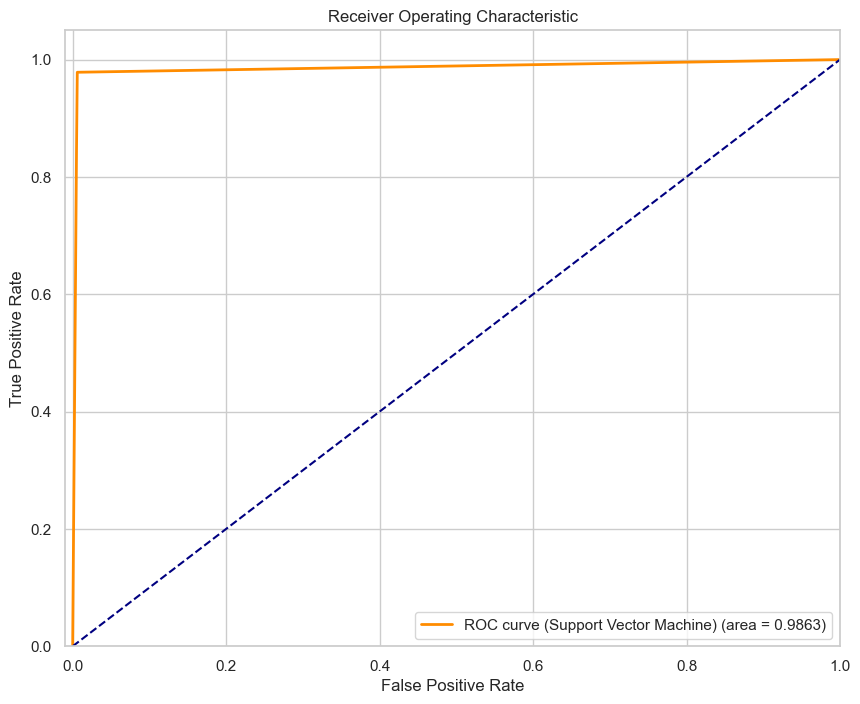

,Accuracy,Precision,Recall,FPR,F1,AUC,Training time,Prediction time
0,0.988921,0.988355,0.978386,0.005789,0.983345,0.986299,6.845987,0.152052
1,0.988921,0.988355,0.978386,0.005789,0.983345,0.986299,5.914962,0.108009
2,0.988921,0.988355,0.978386,0.005789,0.983345,0.986299,4.615621,0.118764
3,0.988921,0.988355,0.978386,0.005789,0.983345,0.986299,2.258974,0.076882
4,0.988921,0.988355,0.978386,0.005789,0.983345,0.986299,2.062496,0.079414


In [11]:
import datetime

import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.utils import shuffle

# Initialize results dictionary for SVM
results["SVM"] = {
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "FPR": [],
    "F1": [],
    "AUC": [],
    "Training time": [],
    "Prediction time": [],
}

# Preprocessing
svm_x_train_ = X_train.fillna(0)
svm_x_test_ = X_test.fillna(0)
svm_y_train_ = y_train.fillna(0)
svm_y_test_ = y_test.fillna(0)

svm_x_train_ = svm_x_train_.to_numpy()
svm_x_test_ = svm_x_test_.to_numpy()
svm_y_train_ = svm_y_train_.to_numpy()
svm_y_test_ = svm_y_test_.to_numpy()

# Converting boolean to 0 and 1
svm_x_train_ = np.where(
    svm_x_train_ == False, 0, np.where(svm_x_train_ == True, 1, svm_x_train_)
)
svm_x_test_ = np.where(
    svm_x_test_ == False, 0, np.where(svm_x_test_== True, 1, svm_x_test_)
)

# MinMax data scaler
scaler = MinMaxScaler()
svm_x_train_scaled = scaler.fit_transform(svm_x_train_)
svm_x_test_scaled = scaler.transform(svm_x_test_)

# Define the parameters
params = {
    "C": 60,  # Regularization parameter
    "gamma": 0.12,  # Kernel coefficient
    "kernel": "rbf",  # ['rbf', 'linear', 'poly', 'sigmoid']
    "shrinking": True, # heuristic method used to reduce computation
    "probability": True, # Estmates class probabilities
    "verbose": False,  # Set to False to avoid excessive output
}

for seed in SEEDS:
    print("-----------------------------------")
    print(f"Support Vector Machine - Seed: {seed}")
    
    # Shuffle
    svm_x_train, svm_y_train = shuffle(svm_x_train_scaled, svm_y_train_, random_state=seed)

    # Create Support Vector Machine model
    svm = SVC(**params, random_state=seed)

    # Measure the training time
    start_time = datetime.datetime.now()
    svm.fit(svm_x_train, svm_y_train)
    end_time = datetime.datetime.now()
    training_time = (end_time - start_time).total_seconds()

    # Measure the prediction time
    start_time = datetime.datetime.now()
    svm_y_pred = svm.predict(svm_x_test_scaled)
    end_time = datetime.datetime.now()
    prediction_time = (end_time - start_time).total_seconds()

    # Compute metrics
    accuracy = accuracy_score(svm_y_test_, svm_y_pred)
    precision = precision_score(svm_y_test_, svm_y_pred)
    recall = recall_score(svm_y_test_, svm_y_pred)
    f1 = f1_score(svm_y_test_, svm_y_pred)
    auc_sc = roc_auc_score(svm_y_test_, svm_y_pred)
    tn, fp, fn, tp = confusion_matrix(svm_y_test_, svm_y_pred).ravel()
    fpr = fp / (fp + tn)

    # Store metrics in results dictionary
    results["SVM"]["Accuracy"].append(accuracy)
    results["SVM"]["Precision"].append(precision)
    results["SVM"]["Recall"].append(recall)
    results["SVM"]["F1"].append(f1)
    results["SVM"]["AUC"].append(auc_sc)
    results["SVM"]["FPR"].append(fpr)
    results["SVM"]["Training time"].append(training_time)
    results["SVM"]["Prediction time"].append(prediction_time)    
    
    # Plot confusion matrix
    plot_confusion_matrix(svm_y_test_, svm_y_pred, classes=["Actual Non-DGA", "Actual DGA"])
    
    # Plot ROC curve
    plot_roc_curve(svm_y_test_, svm_y_pred, classifier_label="Support Vector Machine")
    

# Print the results in a dataframe - well-formatted table
results_df = pd.DataFrame(results["SVM"])
results_df


# Decision Tree

-----------------------------------
Decision Tree - Seed: 58336


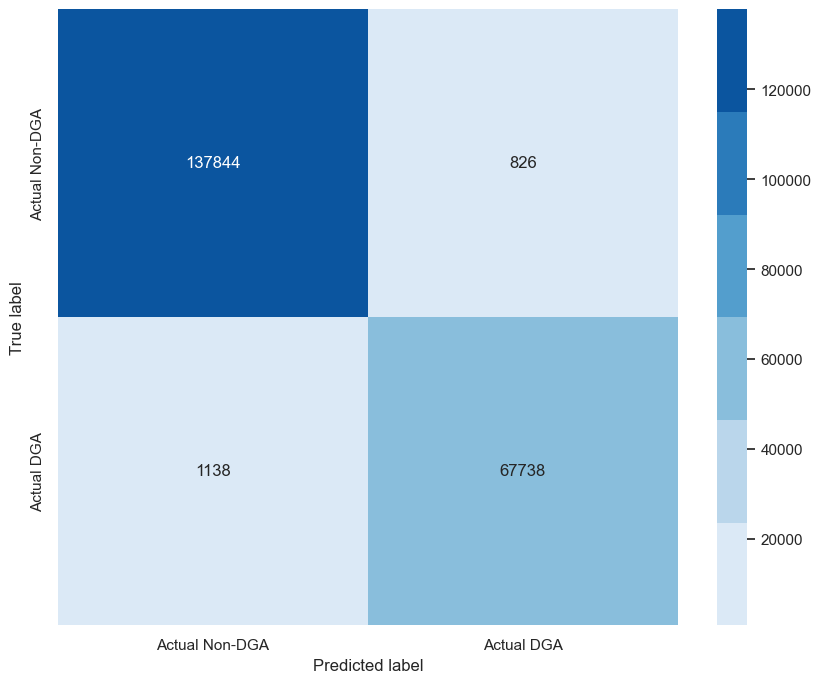

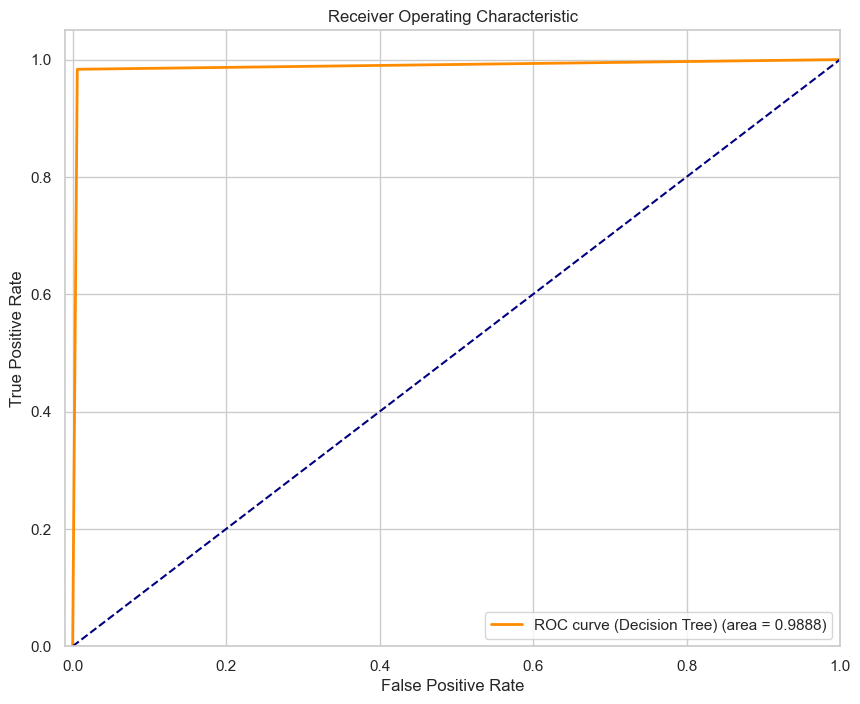

-----------------------------------
Decision Tree - Seed: 48599


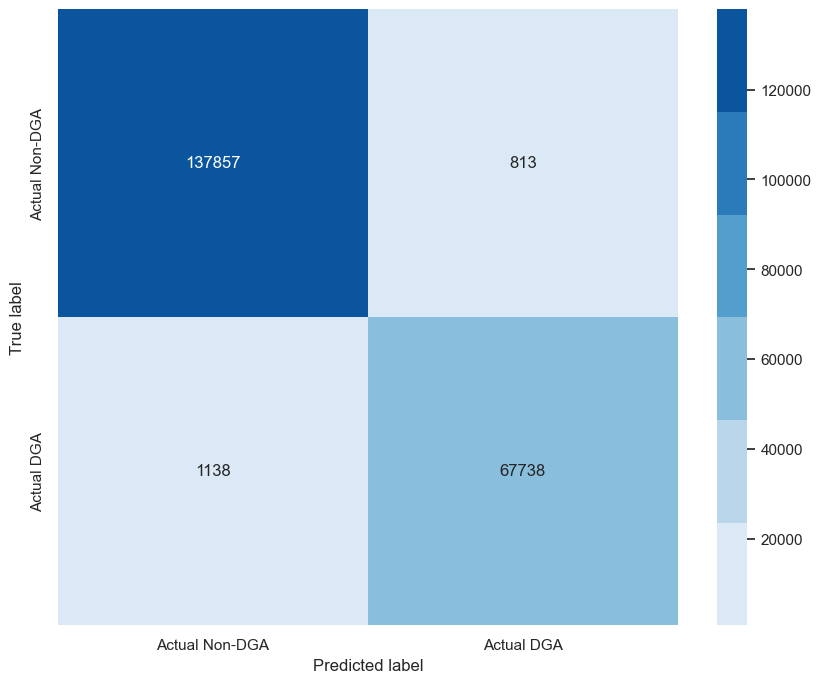

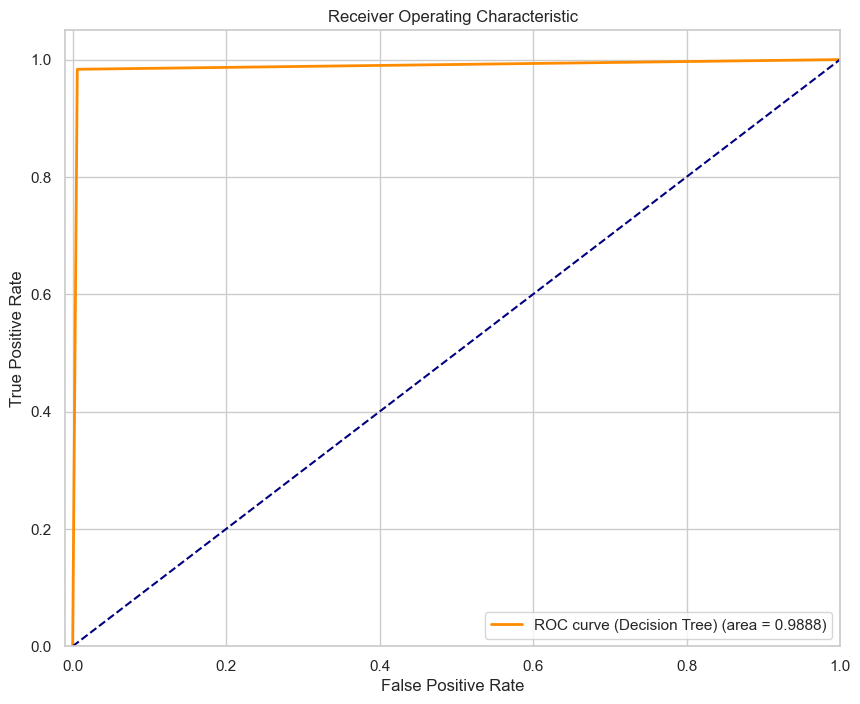

-----------------------------------
Decision Tree - Seed: 47325


KeyboardInterrupt: 

In [47]:
import datetime
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle

# Initialize results dictionary for DT
results["DT"] = {
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "FPR": [],
    "F1": [],
    "AUC": [],
    "Training time": [],
    "Prediction time": [],
}

# Define the parameters
params = {
    "max_depth": 30, # Maximum tree depth to prevent overfitting
    "max_leaf_nodes": 500, # Limits the number of leaf nodes to control tree size
    "min_samples_leaf": 5, # Minimum samples each leaf must have to ensure generalization
    "min_samples_split": 5, # Minimum samples required to split a node, preventing overly complex trees
}

for seed in SEEDS:
    print("-----------------------------------")
    print(f"Decision Tree - Seed: {seed}")
    
    # Shuffle
    dt_x_train, dt_y_train = shuffle(X_train, y_train, random_state=seed)
    
    # Create Decision Tree model with specified parameters
    dt = DecisionTreeClassifier(**params, random_state=seed)

    # Measure the training time
    start_time = datetime.datetime.now()
    dt.fit(dt_x_train, dt_y_train)
    end_time = datetime.datetime.now()
    training_time = (end_time - start_time).total_seconds()

    # Measure the prediction time
    start_time = datetime.datetime.now()
    y_pred = dt.predict(X_test)
    end_time = datetime.datetime.now()
    prediction_time = (end_time - start_time).total_seconds()

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_sc = roc_auc_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fpr = fp / (fp + tn)

    # Store metrics in results dictionary
    results["DT"]["Accuracy"].append(accuracy)
    results["DT"]["Precision"].append(precision)
    results["DT"]["Recall"].append(recall)
    results["DT"]["F1"].append(f1)
    results["DT"]["AUC"].append(auc_sc)
    results["DT"]["FPR"].append(fpr)
    results["DT"]["Training time"].append(training_time)
    results["DT"]["Prediction time"].append(prediction_time)
    
    # Plot confusion matrix
    plot_confusion_matrix(y_test, y_pred, classes=["Actual Non-DGA", "Actual DGA"])
    
    # Plot ROC curve
    plot_roc_curve(y_test, y_pred, classifier_label="Decision Tree")

# Print the results in a dataframe - well-formatted table
results_df = pd.DataFrame(results["DT"])
results_df


# Random Forrest

-----------------------------------
Random Forrest - Seed: 22867


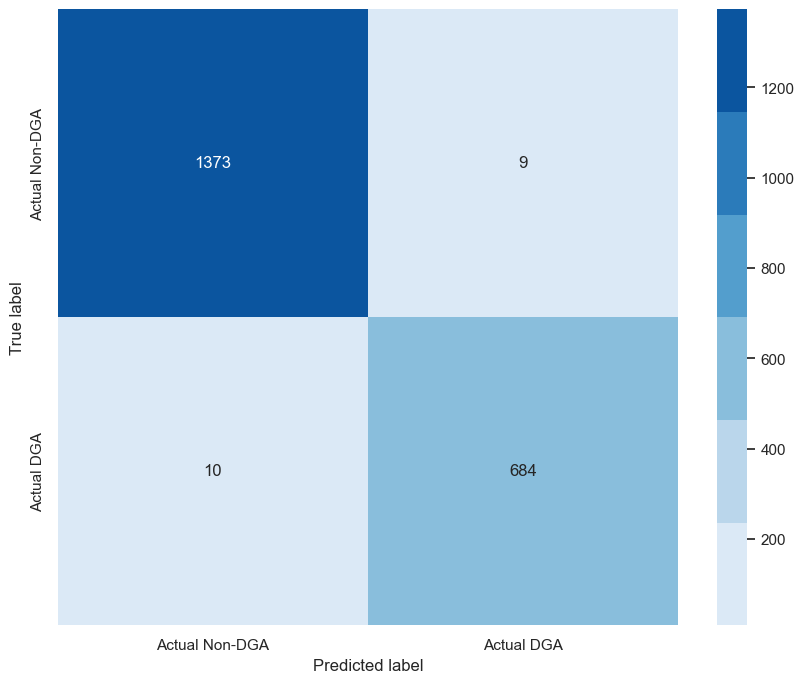

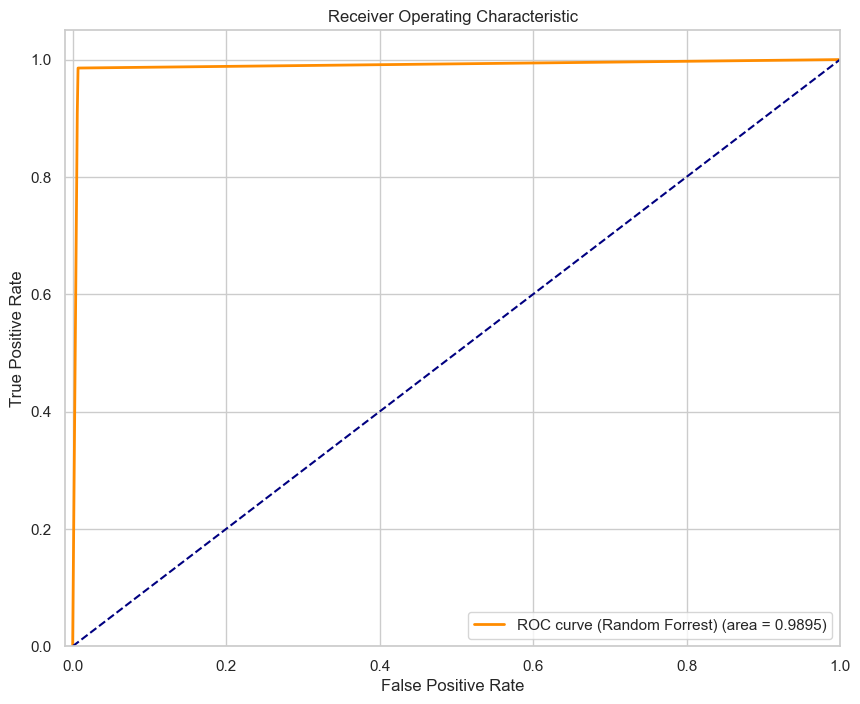

-----------------------------------
Random Forrest - Seed: 20933


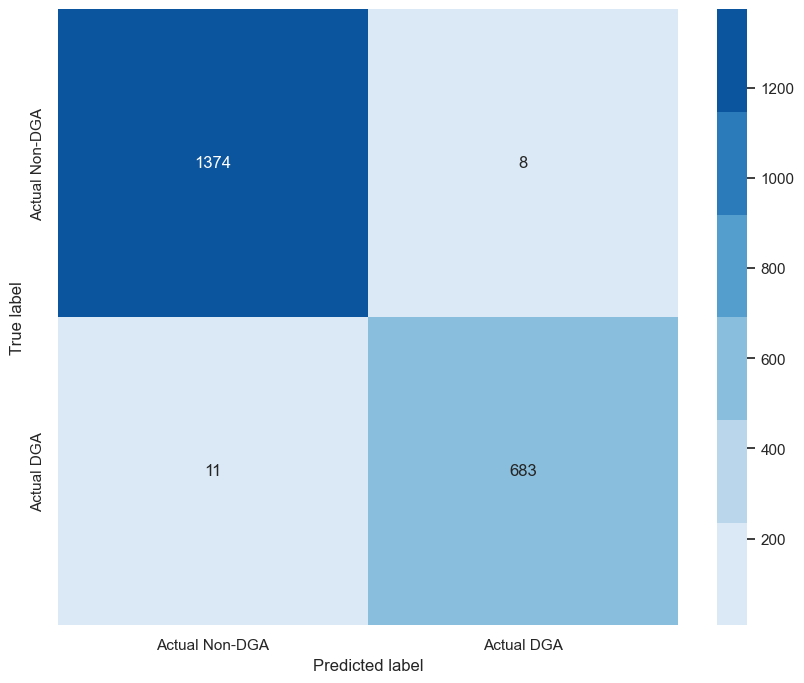

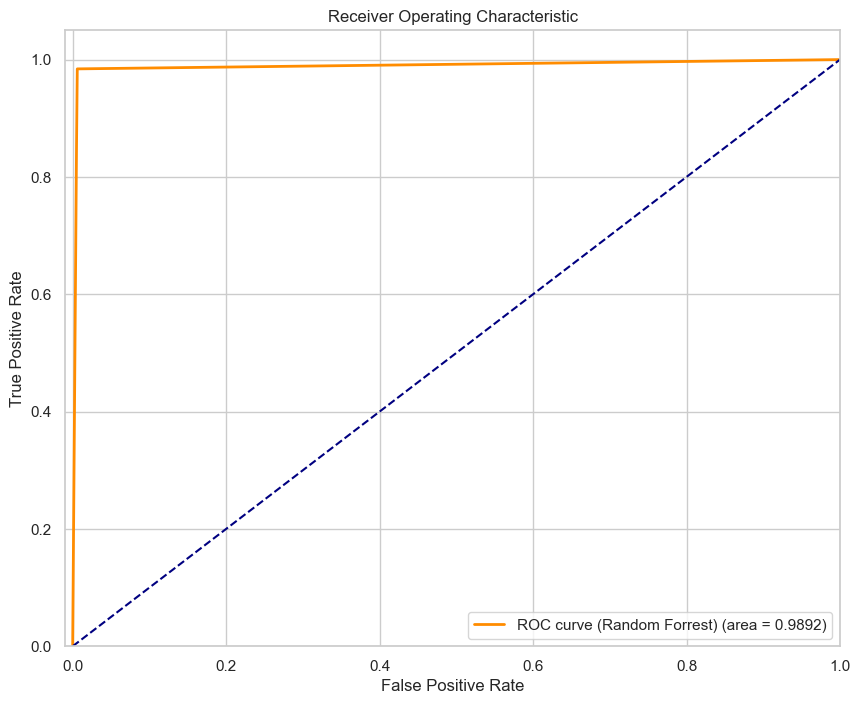

-----------------------------------
Random Forrest - Seed: 46788


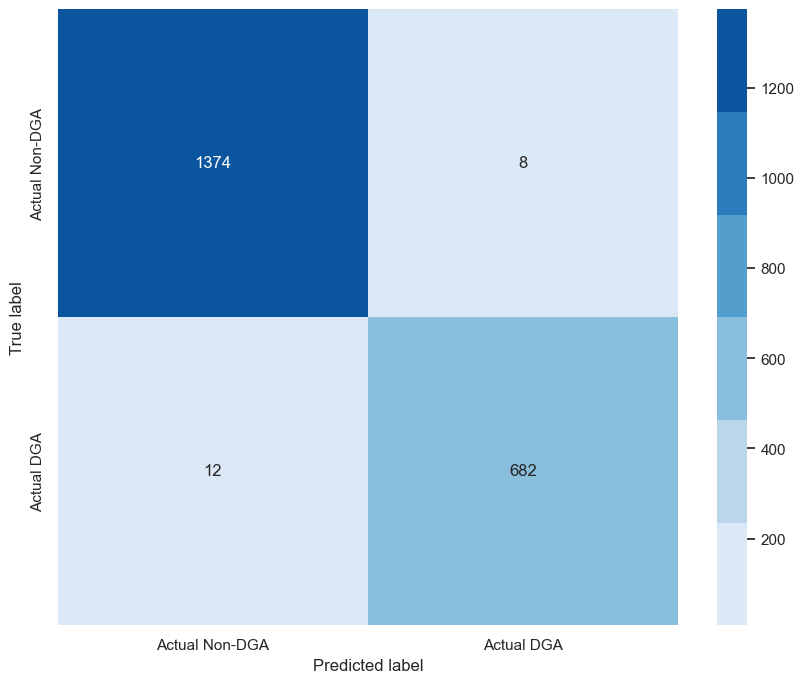

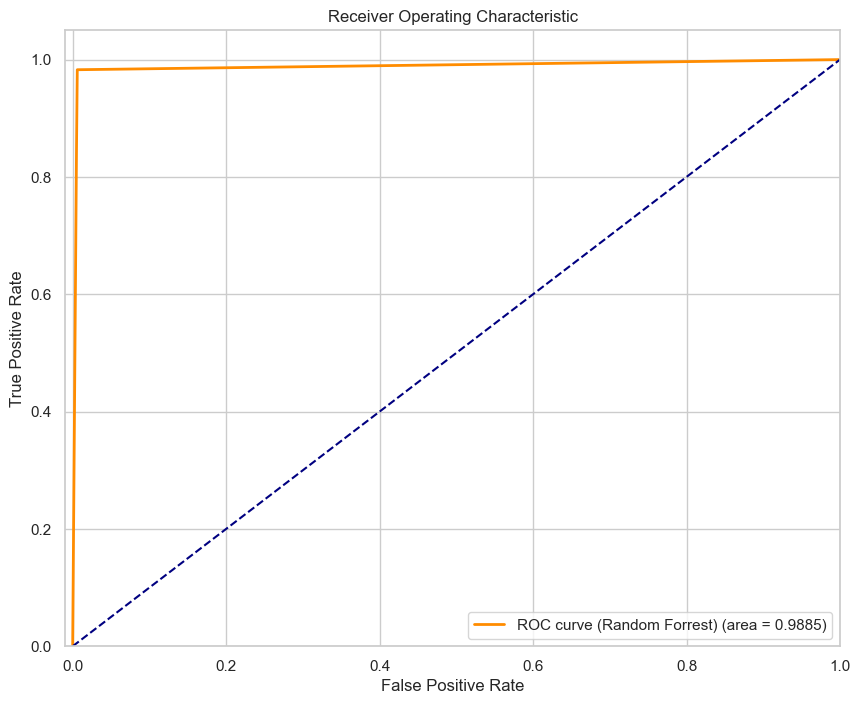

-----------------------------------
Random Forrest - Seed: 18506


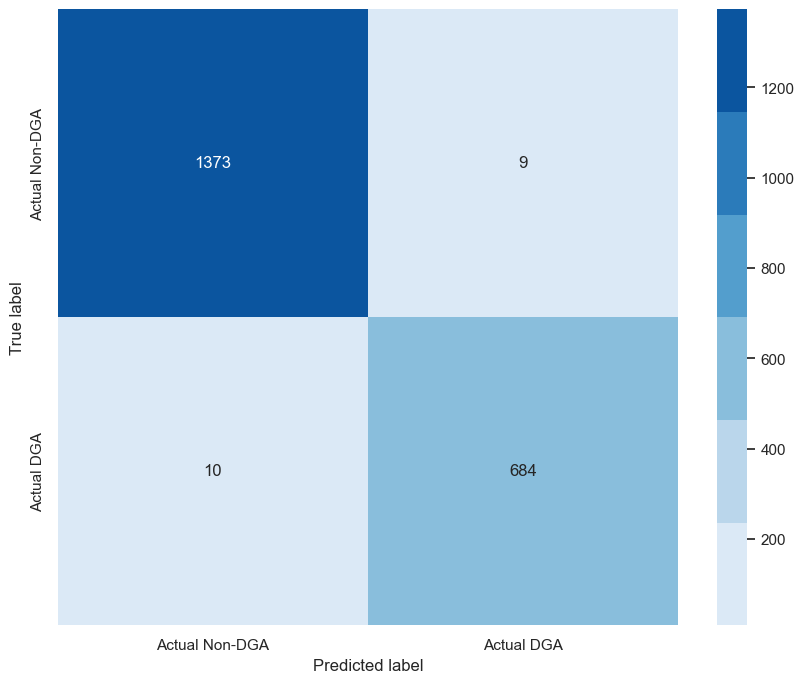

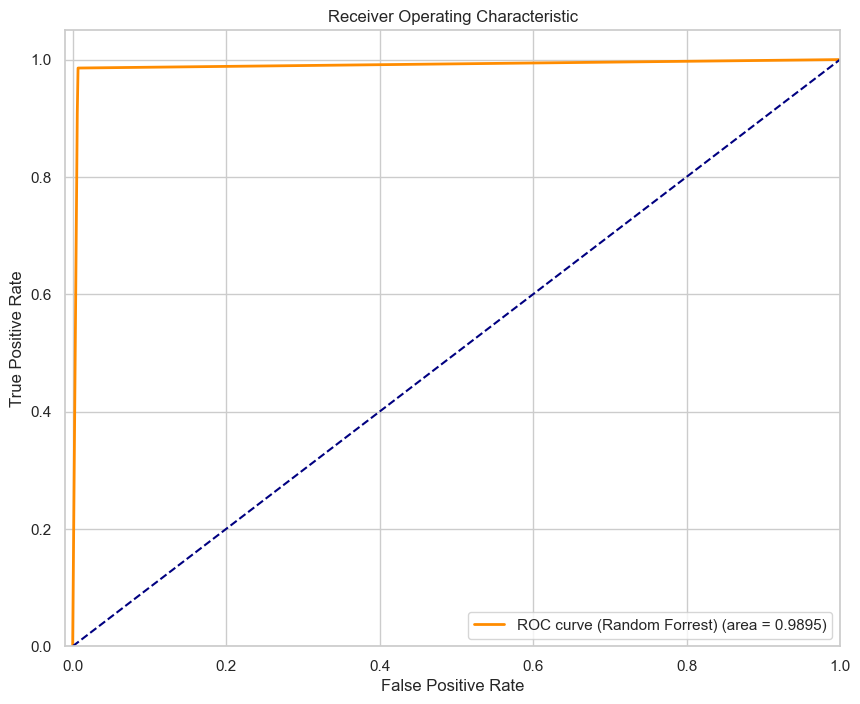

-----------------------------------
Random Forrest - Seed: 36450


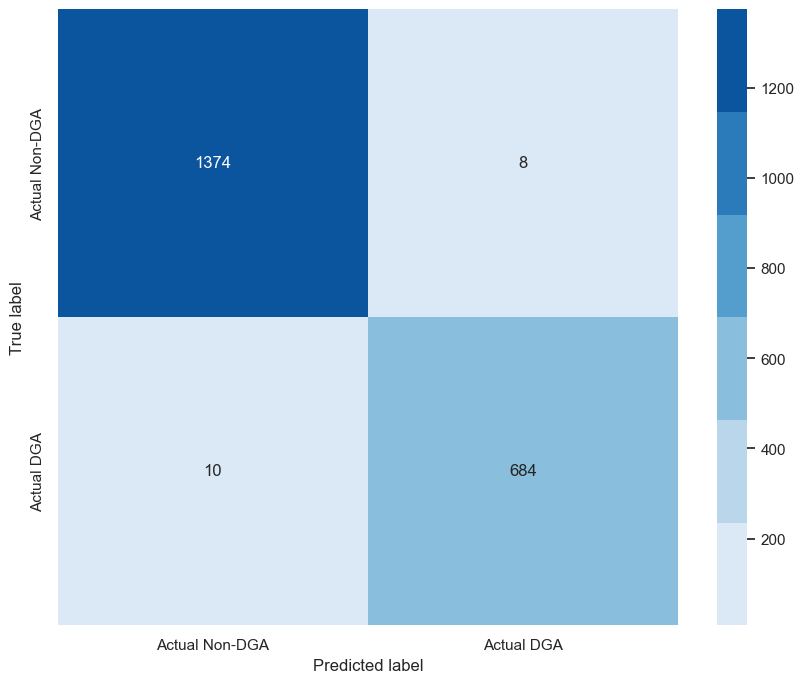

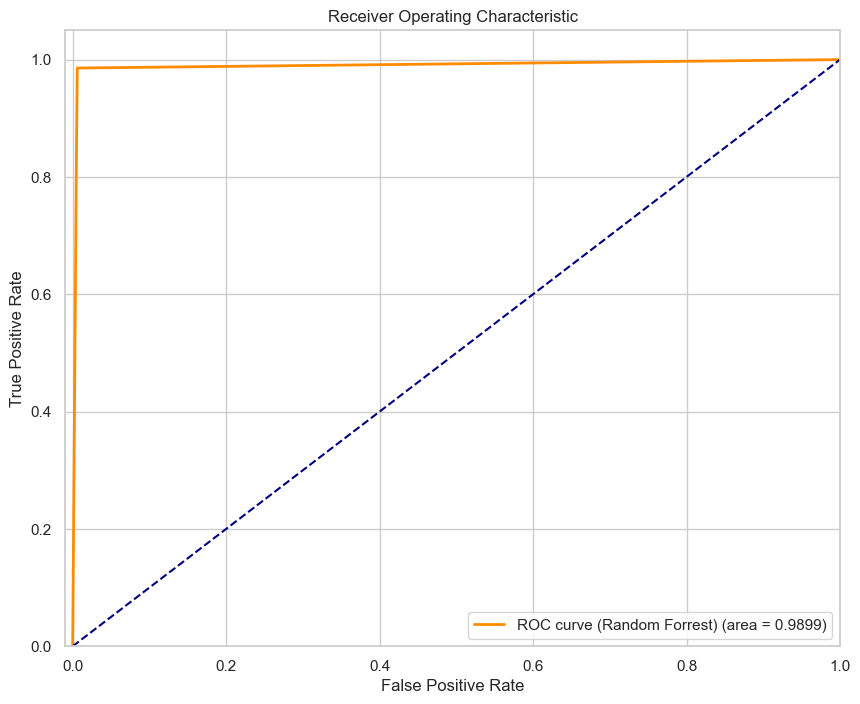

,Accuracy,Precision,Recall,FPR,F1,AUC,Training time,Prediction time
0,0.990848,0.987013,0.985591,0.006512,0.986301,0.989539,1.001758,0.123243
1,0.990848,0.988423,0.984150,0.005789,0.986282,0.989181,0.940356,0.113214
2,0.990366,0.988406,0.982709,0.005789,0.985549,0.988460,0.916781,0.108147
3,0.990848,0.987013,0.985591,0.006512,0.986301,0.989539,1.261146,0.086479
4,0.991329,0.988439,0.985591,0.005789,0.987013,0.989901,0.762999,0.093201


In [13]:
import datetime

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.utils import shuffle

# Initialize results dictionary for RF
results["RF"] = {
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "FPR": [],
    "F1": [],
    "AUC": [],
    "Training time": [],
    "Prediction time": [],
}

# Define the parameters
params = {
    "criterion": "entropy", # The function used to measure the quality of a split
    "class_weight": {0: 1, 1: 5}, # Assigns weights to classes
    "n_estimators": 200, # The number of trees in the forest
    "max_depth": 19, # The maximum depth of each tree
    "min_samples_split": 13, # The minimum number of samples required to split an internal node
    "min_samples_leaf": 1, # The minimum number of samples required to be at a leaf node
    "max_leaf_nodes": None, # The maximum number of leaf nodes a tree can have
}

for seed in SEEDS:
    print("-----------------------------------")
    print(f"Random Forrest - Seed: {seed}")
    
    # Shuffle
    rf_x_train, rf_y_train = shuffle(X_train, y_train, random_state=seed)
    
    # Create Random Forrest model with specified parameters
    rf = RandomForestClassifier(**params, random_state=seed, n_jobs=-1)

    # Measure the training time
    start_time = datetime.datetime.now()
    rf.fit(rf_x_train, rf_y_train)
    end_time = datetime.datetime.now()
    training_time = (end_time - start_time).total_seconds()

    # Measure the prediction time
    start_time = datetime.datetime.now()
    y_pred = rf.predict(X_test)
    end_time = datetime.datetime.now()
    prediction_time = (end_time - start_time).total_seconds()

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_sc = roc_auc_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fpr = fp / (fp + tn)

    # Store metrics in results dictionary
    results["RF"]["Accuracy"].append(accuracy)
    results["RF"]["Precision"].append(precision)
    results["RF"]["Recall"].append(recall)
    results["RF"]["F1"].append(f1)
    results["RF"]["AUC"].append(auc_sc)
    results["RF"]["FPR"].append(fpr)
    results["RF"]["Training time"].append(training_time)
    results["RF"]["Prediction time"].append(prediction_time)
    
    # Plot confusion matrix
    plot_confusion_matrix(y_test, y_pred, classes=["Actual Non-DGA", "Actual DGA"])
    
    # Plot ROC curve
    plot_roc_curve(y_test, y_pred, classifier_label="Random Forrest")

# Print the results in a dataframe - well-formatted table
results_df = pd.DataFrame(results["RF"])
results_df


# AdaBoost

-----------------------------------
AdaBoost - Seed: 22867


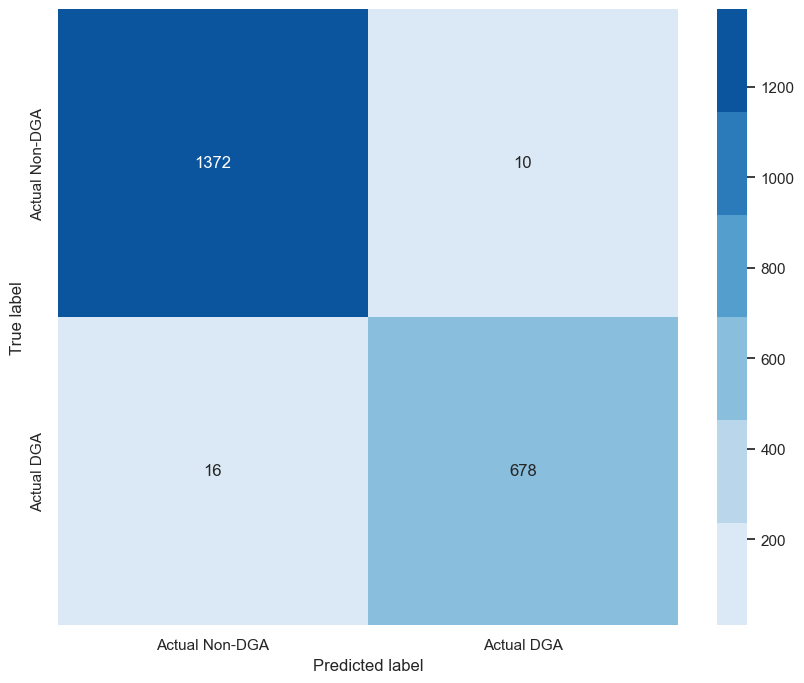

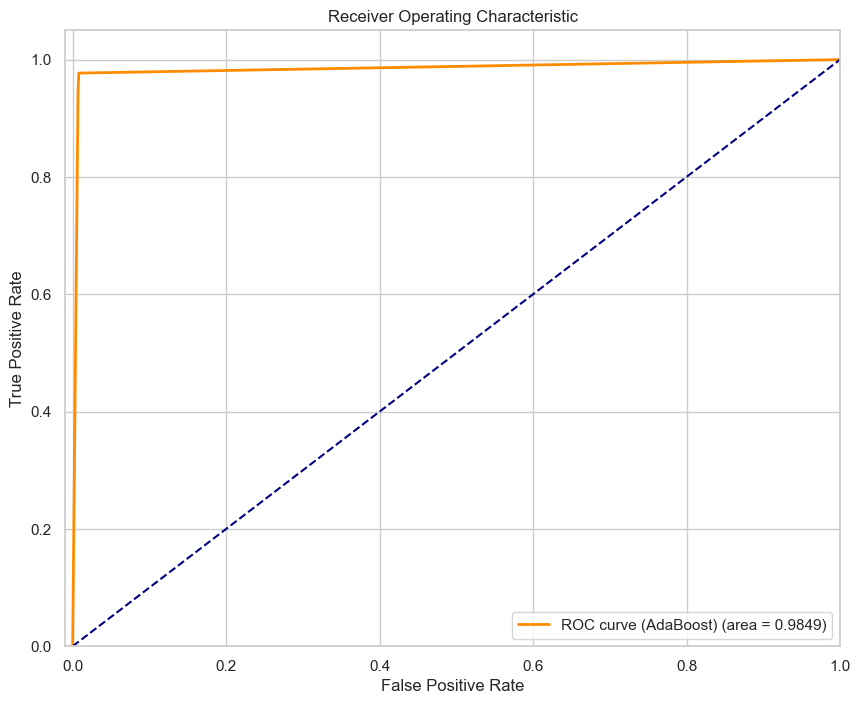

-----------------------------------
AdaBoost - Seed: 20933


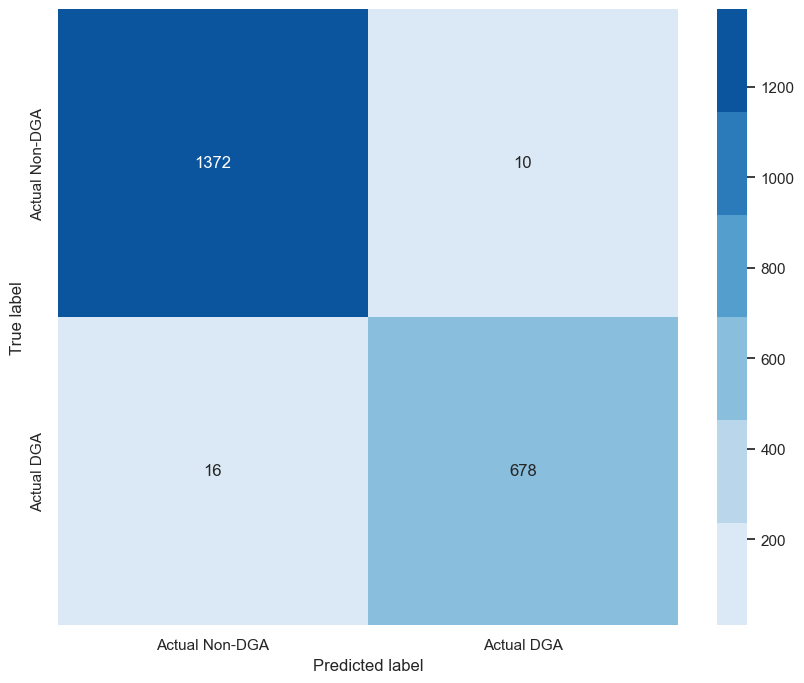

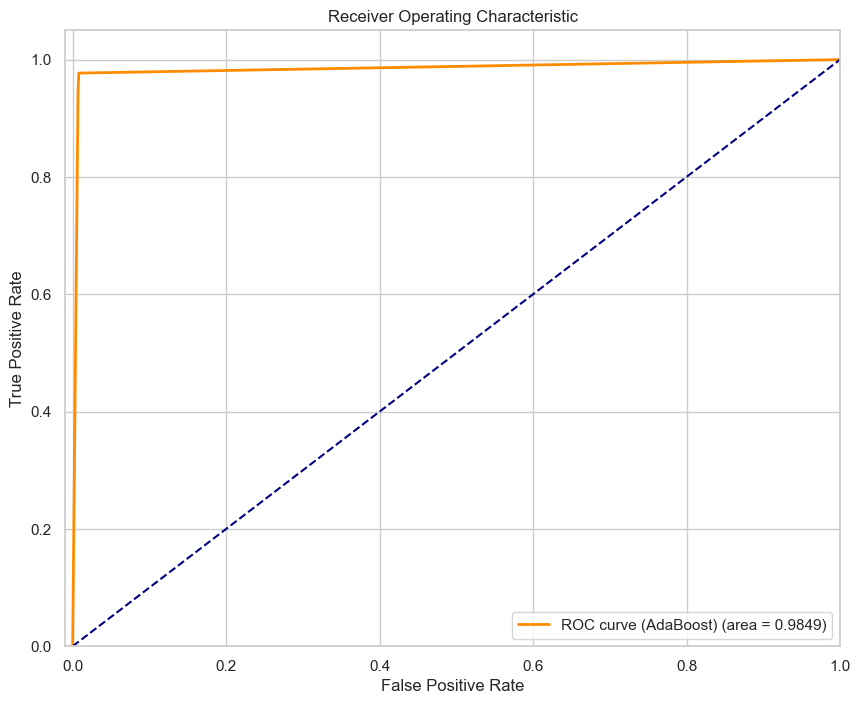

-----------------------------------
AdaBoost - Seed: 46788


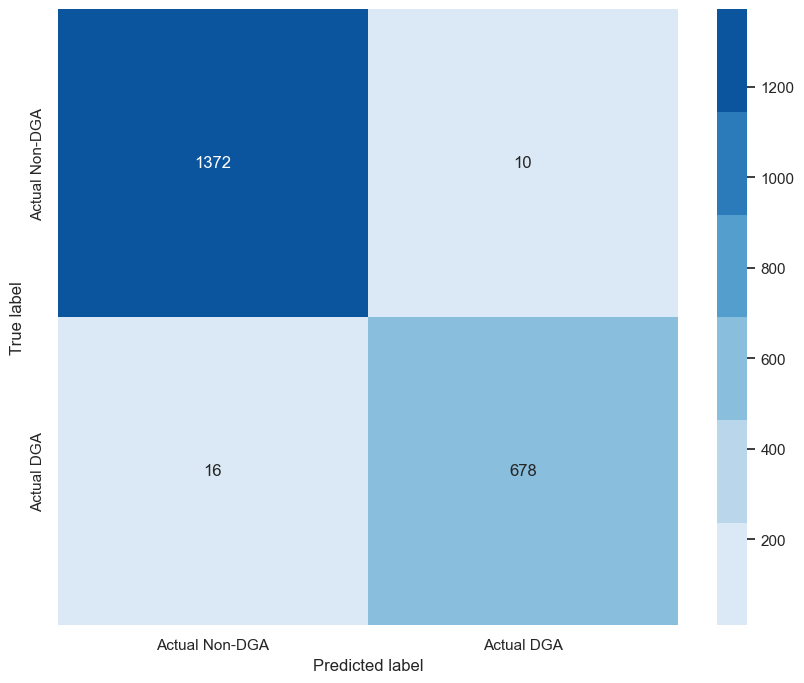

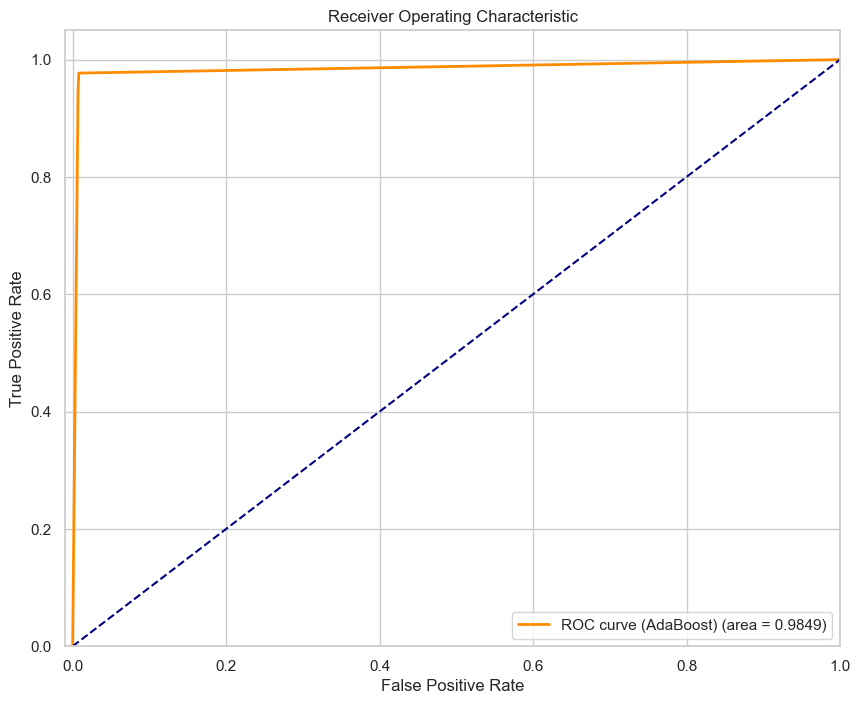

-----------------------------------
AdaBoost - Seed: 18506


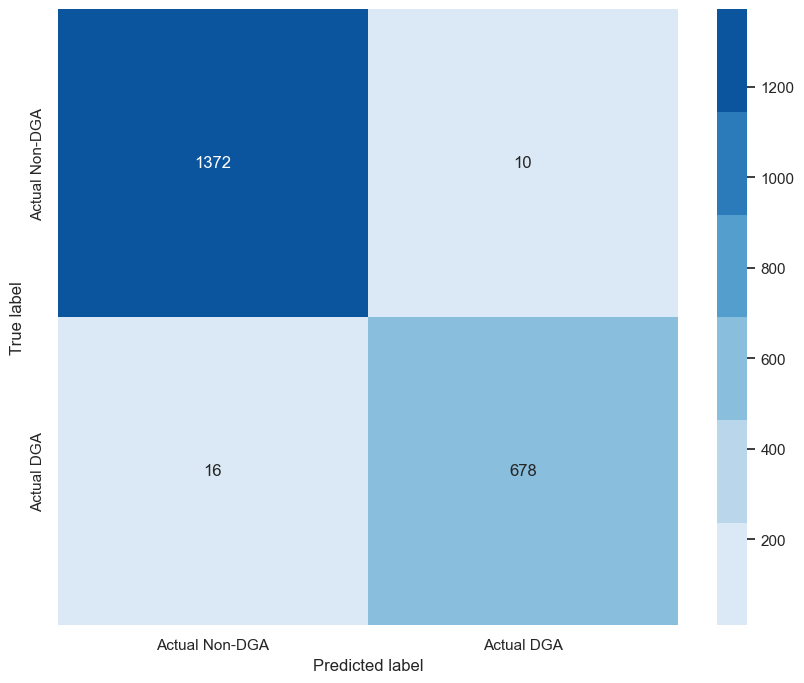

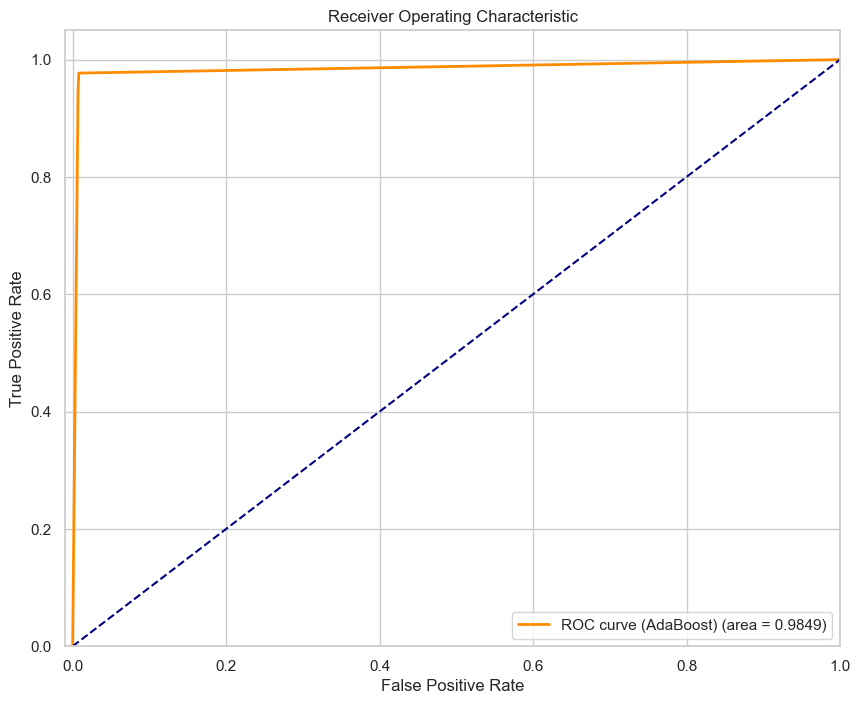

-----------------------------------
AdaBoost - Seed: 36450


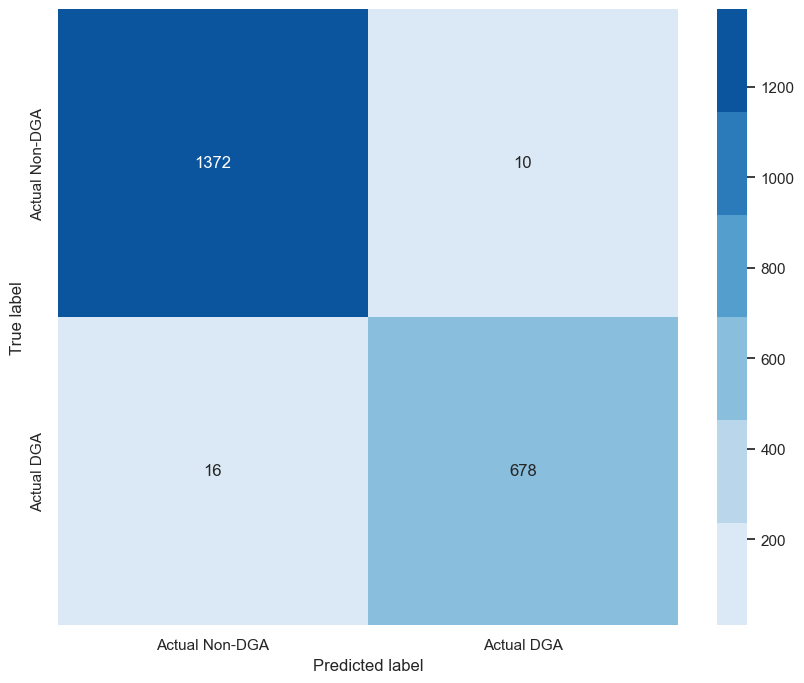

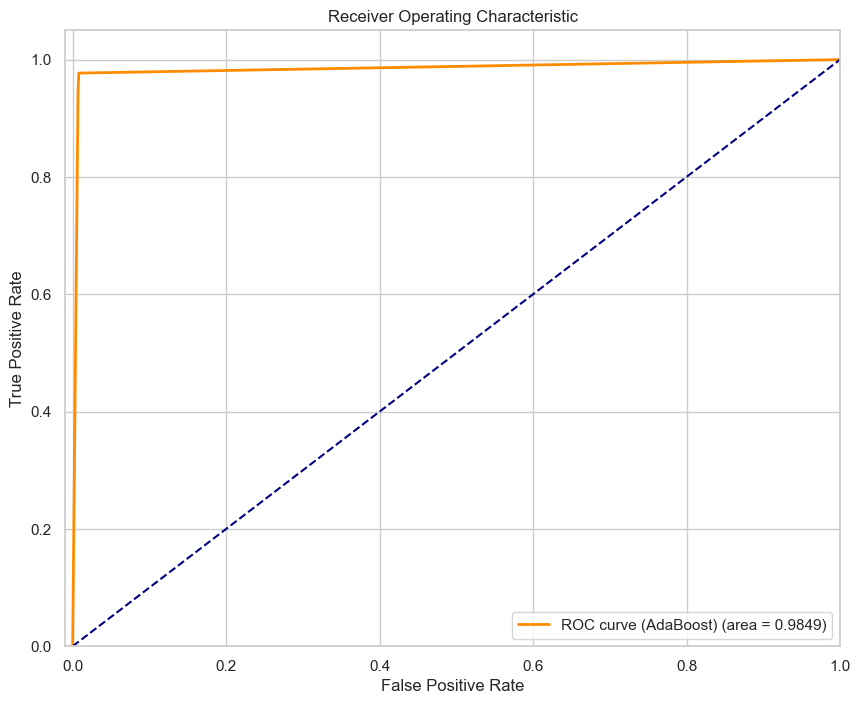

,Accuracy,Precision,Recall,FPR,F1,AUC,Training time,Prediction time
0,0.987476,0.985465,0.976945,0.007236,0.981187,0.984855,6.070374,0.152575
1,0.987476,0.985465,0.976945,0.007236,0.981187,0.984855,5.866881,0.175116
2,0.987476,0.985465,0.976945,0.007236,0.981187,0.984855,5.053278,0.116278
3,0.987476,0.985465,0.976945,0.007236,0.981187,0.984855,5.294164,0.114342
4,0.987476,0.985465,0.976945,0.007236,0.981187,0.984855,3.676302,0.078172


In [14]:
import datetime

import pandas as pd
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle

# Initialize results dictionary for AdaBoost
results["AdaBoost"] = {
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "FPR": [],
    "F1": [],
    "AUC": [],
    "Training time": [],
    "Prediction time": [],
}

# Define the parameters
params = {
    "learning_rate": 0.4, # Controls the contribution of each weak classifier in the final combination
    "estimator": DecisionTreeClassifier(max_depth=2), # Specifies the type of weak learner used for boosting
    "n_estimators": 250, # Sets the maximum number of weak learners to be used
}

for seed in SEEDS:
    print("-----------------------------------")
    print(f"AdaBoost - Seed: {seed}")
    
    # Shuffle
    ada_x_train, ada_y_train = shuffle(X_train, y_train, random_state=seed)
    
    # Create AdaBoost model with specified parameters
    adaboost = AdaBoostClassifier(**params, random_state=seed)

    # Measure the training time
    start_time = datetime.datetime.now()
    adaboost.fit(ada_x_train, ada_y_train)
    end_time = datetime.datetime.now()
    training_time = (end_time - start_time).total_seconds()

    # Measure the prediction time
    start_time = datetime.datetime.now()
    y_pred = adaboost.predict(X_test)
    end_time = datetime.datetime.now()
    prediction_time = (end_time - start_time).total_seconds()

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_sc = roc_auc_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fpr = fp / (fp + tn)

    # Store metrics in results dictionary
    results["AdaBoost"]["Accuracy"].append(accuracy)
    results["AdaBoost"]["Precision"].append(precision)
    results["AdaBoost"]["Recall"].append(recall)
    results["AdaBoost"]["F1"].append(f1)
    results["AdaBoost"]["AUC"].append(auc_sc)
    results["AdaBoost"]["FPR"].append(fpr)
    results["AdaBoost"]["Training time"].append(training_time)
    results["AdaBoost"]["Prediction time"].append(prediction_time)

    # Plot confusion matrix
    plot_confusion_matrix(y_test, y_pred, classes=["Actual Non-DGA", "Actual DGA"])

    # Plot ROC curve
    plot_roc_curve(y_test, y_pred, classifier_label="AdaBoost")

# Print the results in a dataframe - well-formatted table
results_df = pd.DataFrame(results["AdaBoost"])
results_df


# XGBoost

-----------------------------------
XGBoost - Seed: 22867


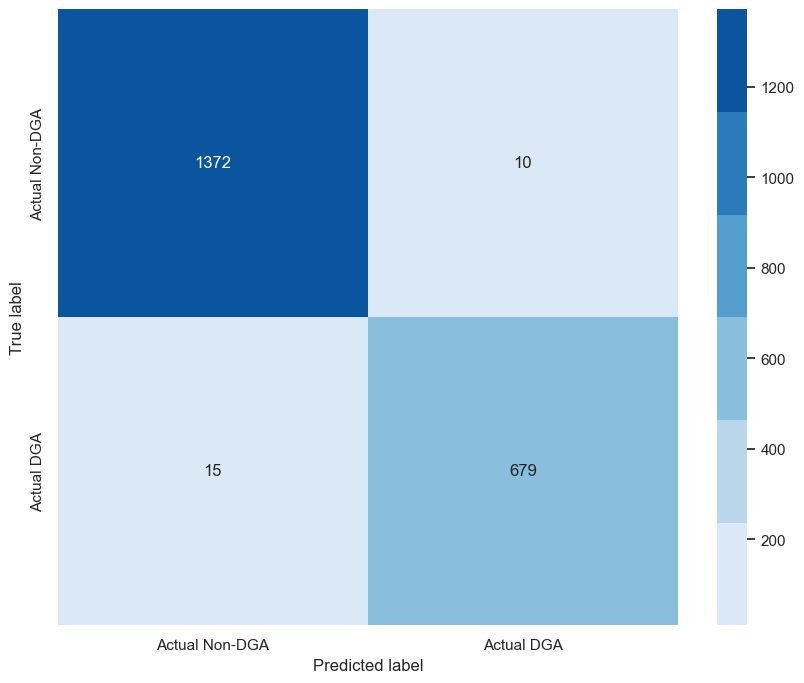

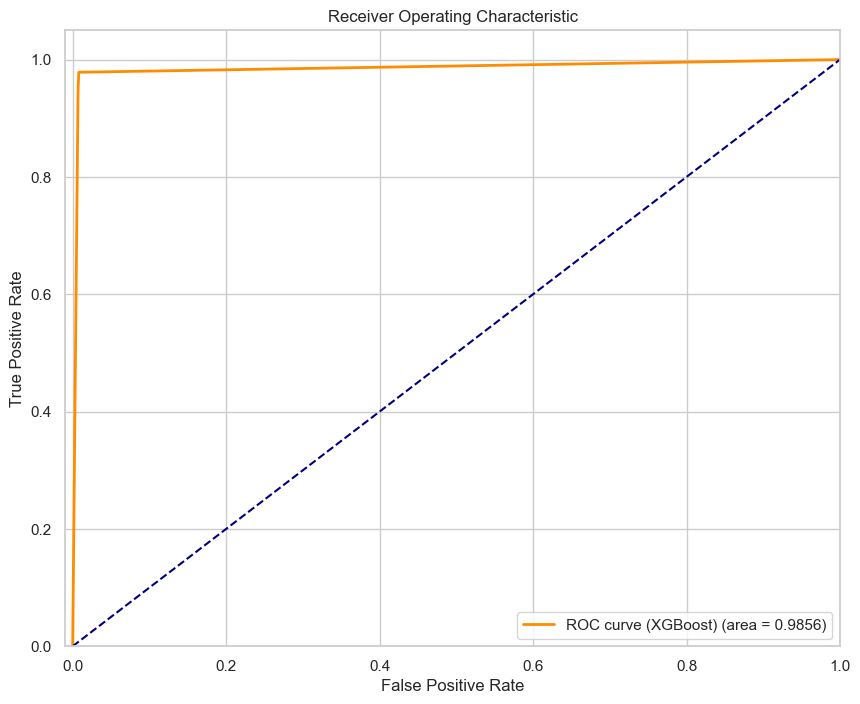

-----------------------------------
XGBoost - Seed: 20933


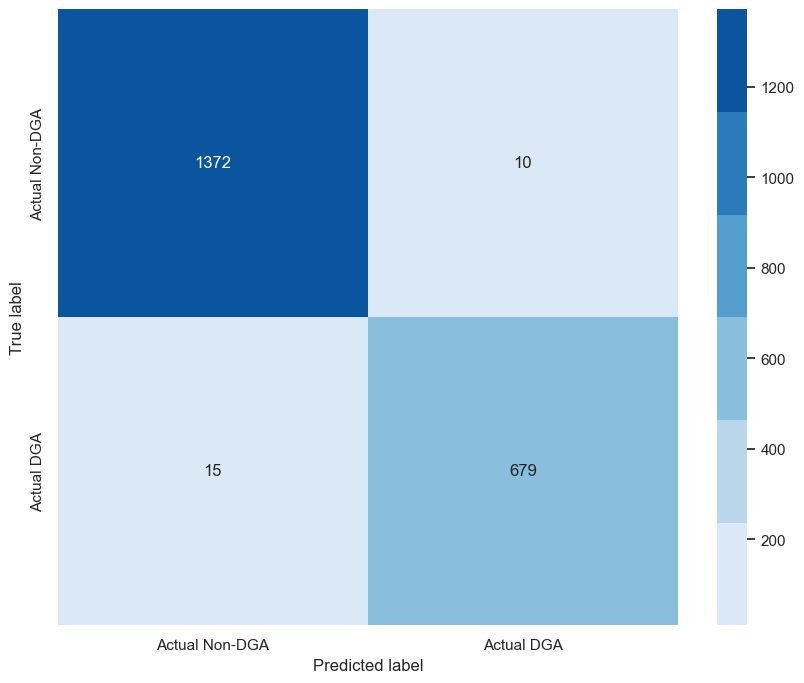

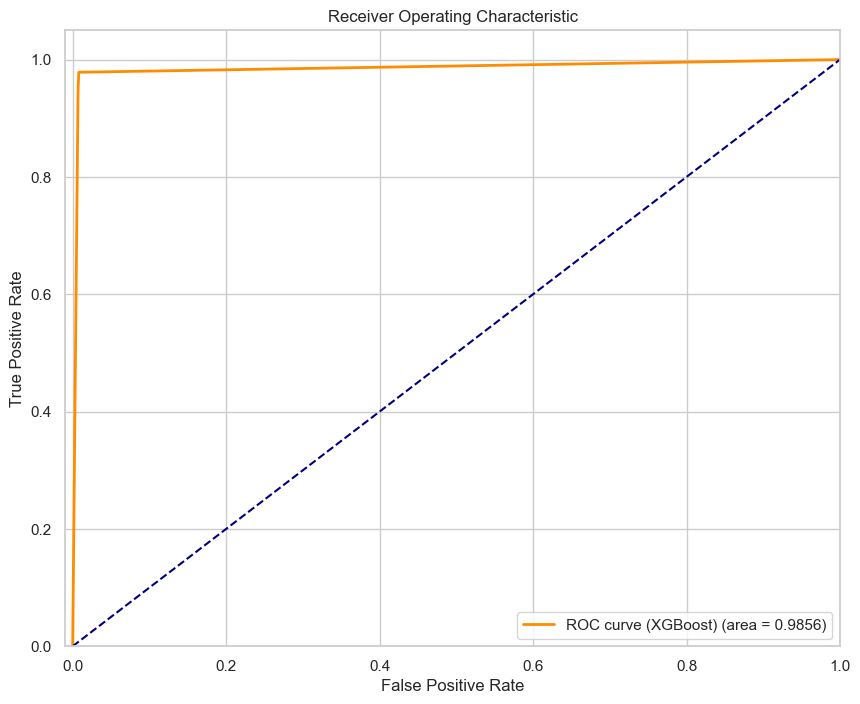

-----------------------------------
XGBoost - Seed: 46788


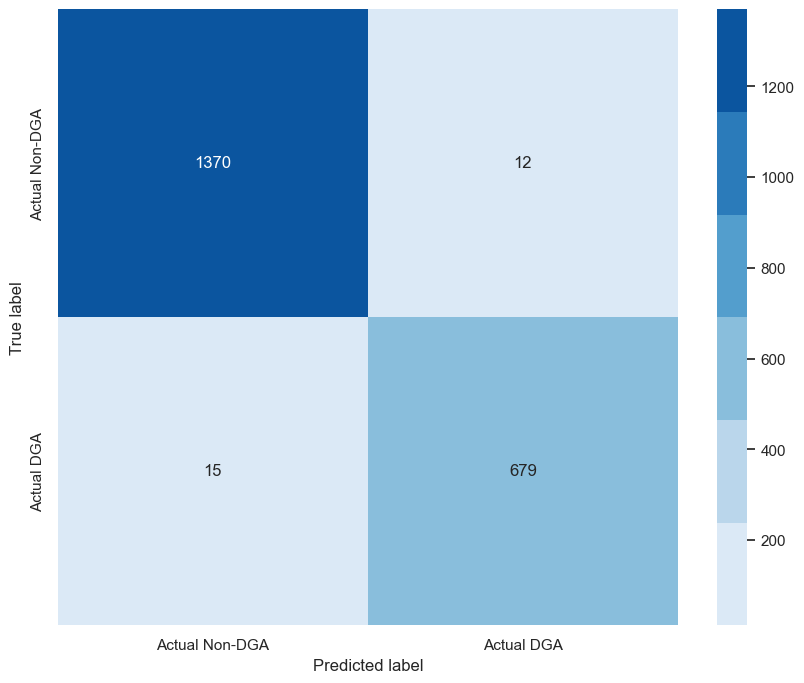

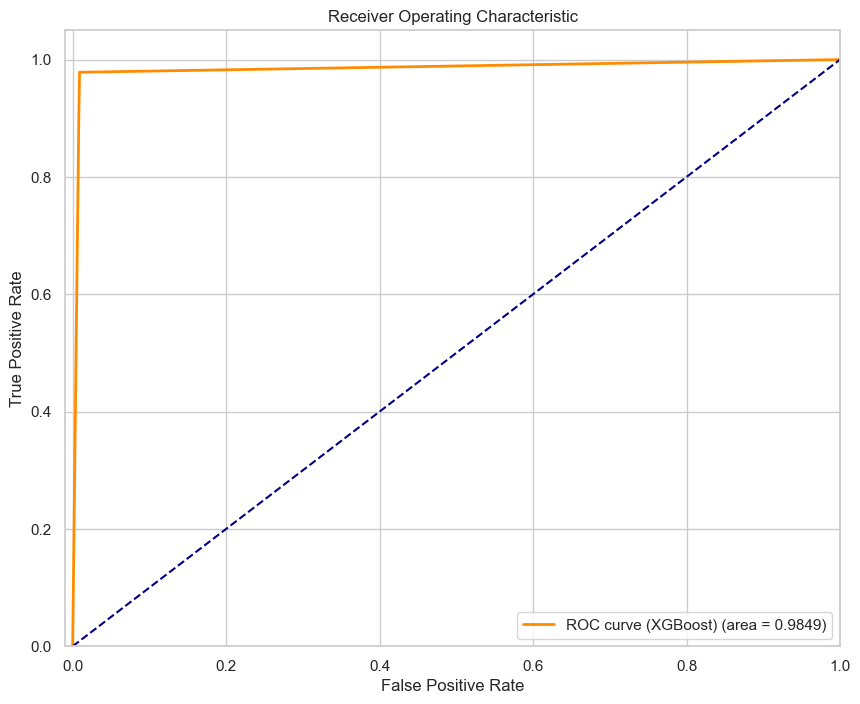

-----------------------------------
XGBoost - Seed: 18506


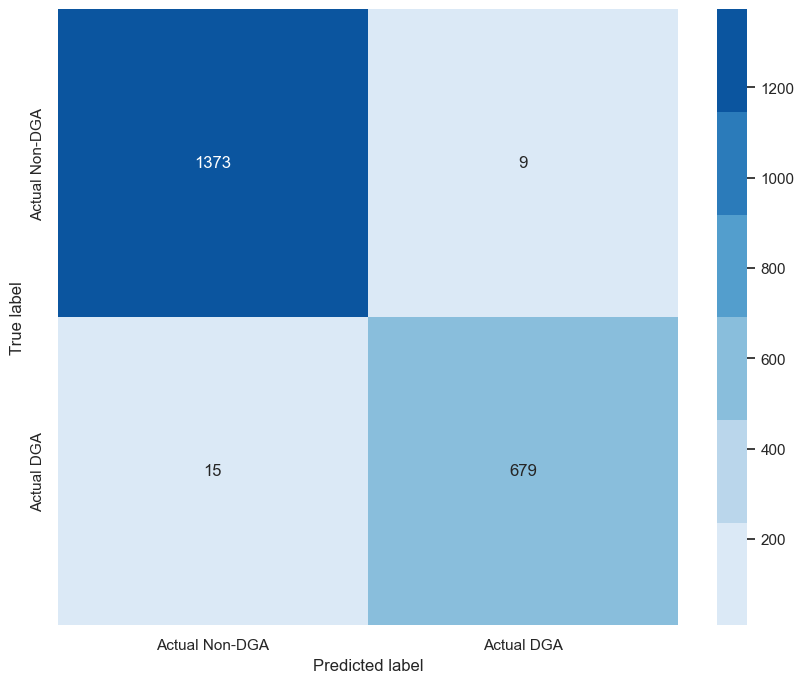

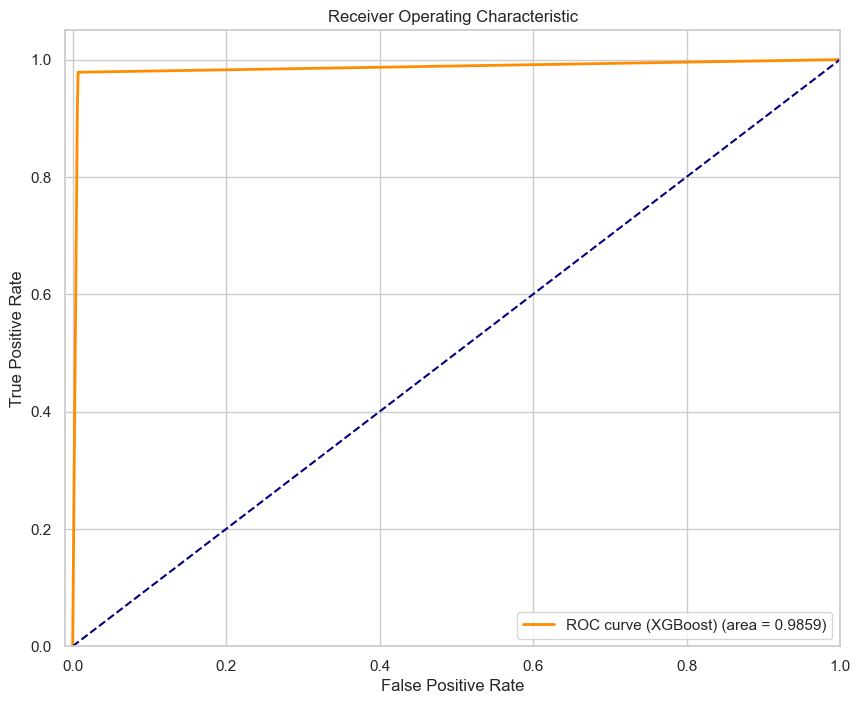

-----------------------------------
XGBoost - Seed: 36450


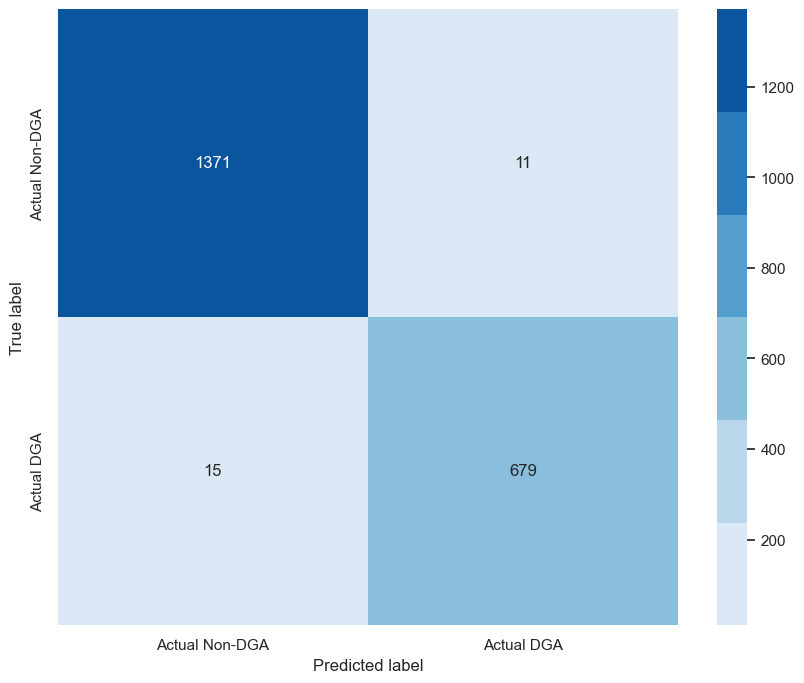

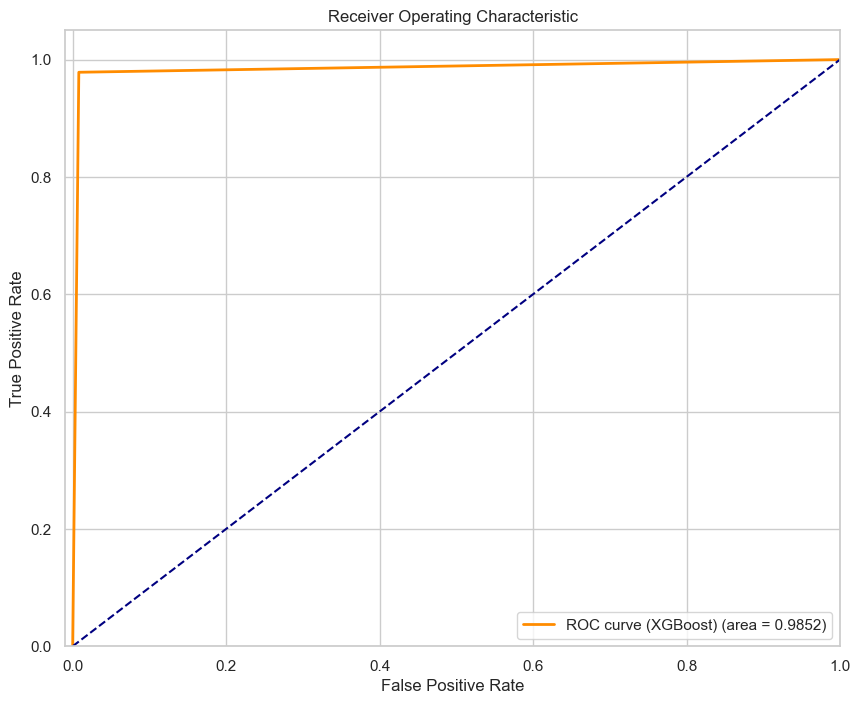

,Accuracy,Precision,Recall,FPR,F1,AUC,Training time,Prediction time
0,0.987958,0.985486,0.978386,0.007236,0.981923,0.985575,0.651660,0.013879
1,0.987958,0.985486,0.978386,0.007236,0.981923,0.985575,0.621751,0.015915
2,0.986994,0.982634,0.978386,0.008683,0.980505,0.984852,0.624251,0.014531
3,0.988439,0.986919,0.978386,0.006512,0.982634,0.985937,0.577860,0.014543
4,0.987476,0.984058,0.978386,0.007959,0.981214,0.985213,0.590955,0.014829


In [15]:
import datetime

import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.utils import shuffle

# Initialize results dictionary for XGBoost
results["XGBoost"] = {
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "FPR": [],
    "F1": [],
    "AUC": [],
    "Training time": [],
    "Prediction time": [],
}

# Define the parameters
params = {
    "objective": "binary:logistic", # The learning task and the corresponding learning objective
    "tree_method": "hist", # The algorithm used for constructing the trees.
    "sampling_method": "uniform", # Indicates the method for sampling training instances
    "eval_metric": ["error", "logloss", "auc"], # Defines the evaluation metrics used to assess the model during training
    "grow_policy": "depthwise", # Determines the strategy for growing trees
    "gamma": 0.1, # Sets the minimum loss reduction required to make a further partition on a leaf node
    "lambda": 1.0, # Specifies L2 regularization term on weights, which helps to control over-fitting by penalizing large weights.
    "eta": 0.1, # Represents the learning rate, shrinking the feature weights to make the boosting process more conservative.
    "max_delta_step": 0, # Maximizes the step size used in each tree’s weight estimation to make the model more robust.
    "max_bin": 512, # The maximum number of bins used for bucketing feature values (histograms), used in the "hist" tree method
    "min_child_weight": 2, # Defines the minimum sum of instance weight (hessian) needed in a child node
    "subsample": 0.6, # Fraction of the training samples to be randomly sampled for each tree
    "max_depth": 12, # The maximum depth of a tree, limiting the number of nodes in the tree
    "n_estimators": 500, # Number of gradient boosted trees. Equivalent to the number of boosting rounds
    "scale_pos_weight": 1, # Balancing of positive and negative weights
}

for seed in SEEDS:
    print("-----------------------------------")
    print(f"XGBoost - Seed: {seed}")
    
    # Shuffle
    xgb_x_train, xgb_y_train = shuffle(X_train, y_train, random_state=seed)
    
    # Create AdaBoost model with specified parameters
    xgboost = XGBClassifier(**params, random_state=seed, n_jobs=-1)

    # Measure the training time
    start_time = datetime.datetime.now()
    xgboost.fit(xgb_x_train, xgb_y_train)
    end_time = datetime.datetime.now()
    training_time = (end_time - start_time).total_seconds()

    # Measure the prediction time
    start_time = datetime.datetime.now()
    y_pred = xgboost.predict(X_test)
    end_time = datetime.datetime.now()
    prediction_time = (end_time - start_time).total_seconds()

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_sc = roc_auc_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fpr = fp / (fp + tn)

    # Store metrics in results dictionary
    results["XGBoost"]["Accuracy"].append(accuracy)
    results["XGBoost"]["Precision"].append(precision)
    results["XGBoost"]["Recall"].append(recall)
    results["XGBoost"]["F1"].append(f1)
    results["XGBoost"]["AUC"].append(auc_sc)
    results["XGBoost"]["FPR"].append(fpr)
    results["XGBoost"]["Training time"].append(training_time)
    results["XGBoost"]["Prediction time"].append(prediction_time)

    # Plot confusion matrix
    plot_confusion_matrix(y_test, y_pred, classes=["Actual Non-DGA", "Actual DGA"])

    # Plot ROC curve
    plot_roc_curve(y_test, y_pred, classifier_label="XGBoost")

# Print the results in a dataframe - well-formatted table
results_df = pd.DataFrame(results["XGBoost"])
results_df

In [10]:
SEEDS = generate_random_seeds(count=5)

TypeError: Random.randint() missing 2 required positional arguments: 'a' and 'b'

# LightGBM

-----------------------------------
LightGBM - Seed: 51002
[LightGBM] [Info] Number of positive: 160711, number of negative: 323561
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.219391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4130
[LightGBM] [Info] Number of data points in the train set: 484272, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.331861 -> initscore=-0.699780
[LightGBM] [Info] Start training from score -0.699780


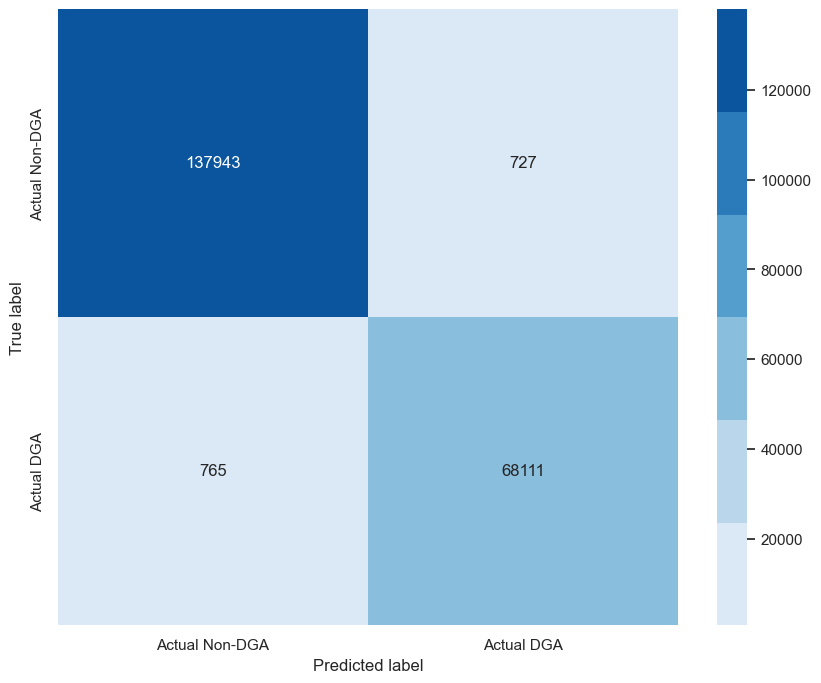

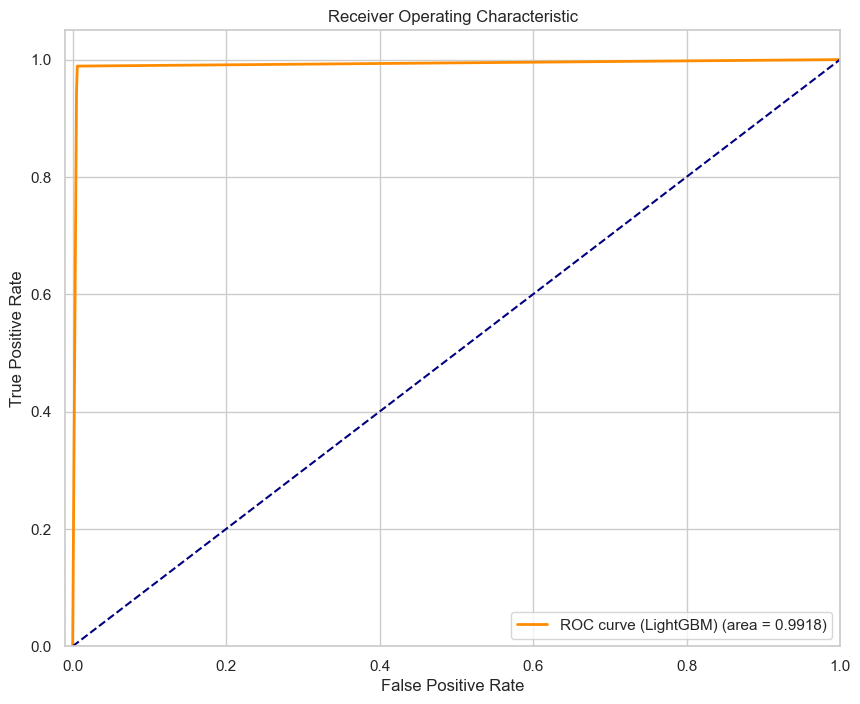

-----------------------------------
LightGBM - Seed: 28147
[LightGBM] [Info] Number of positive: 160711, number of negative: 323561
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4118
[LightGBM] [Info] Number of data points in the train set: 484272, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.331861 -> initscore=-0.699780
[LightGBM] [Info] Start training from score -0.699780


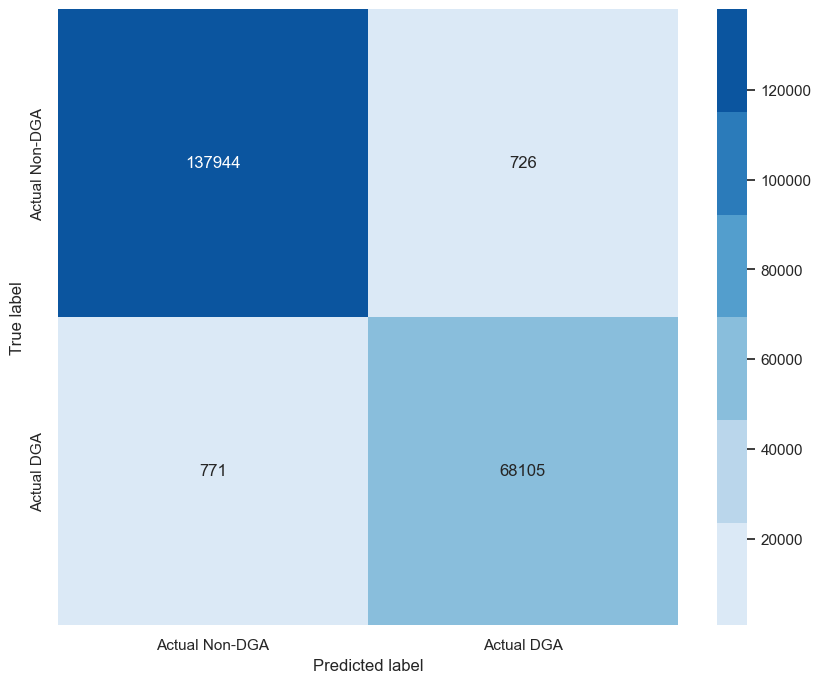

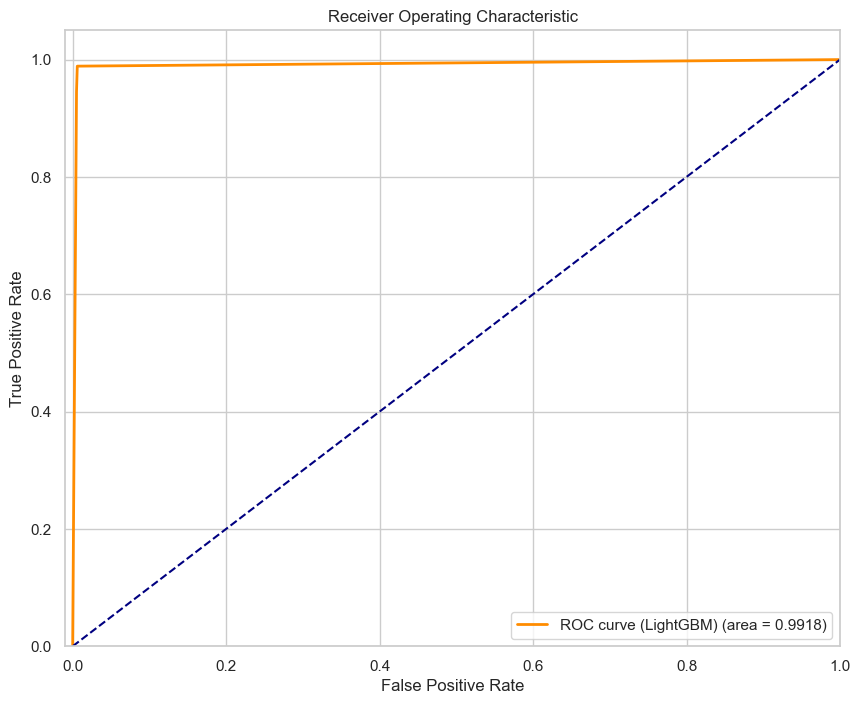

-----------------------------------
LightGBM - Seed: 27962
[LightGBM] [Info] Number of positive: 160711, number of negative: 323561
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035190 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4150
[LightGBM] [Info] Number of data points in the train set: 484272, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.331861 -> initscore=-0.699780
[LightGBM] [Info] Start training from score -0.699780


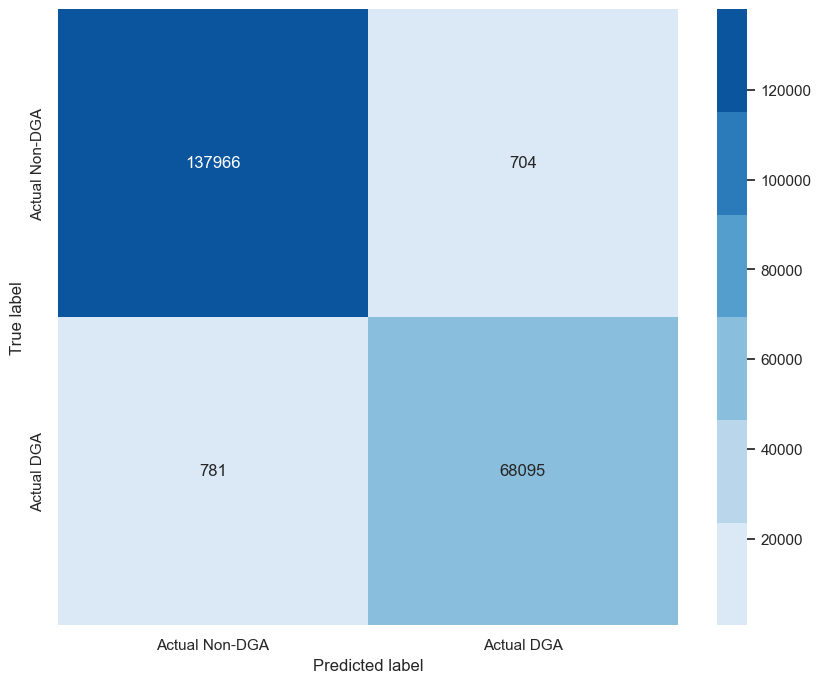

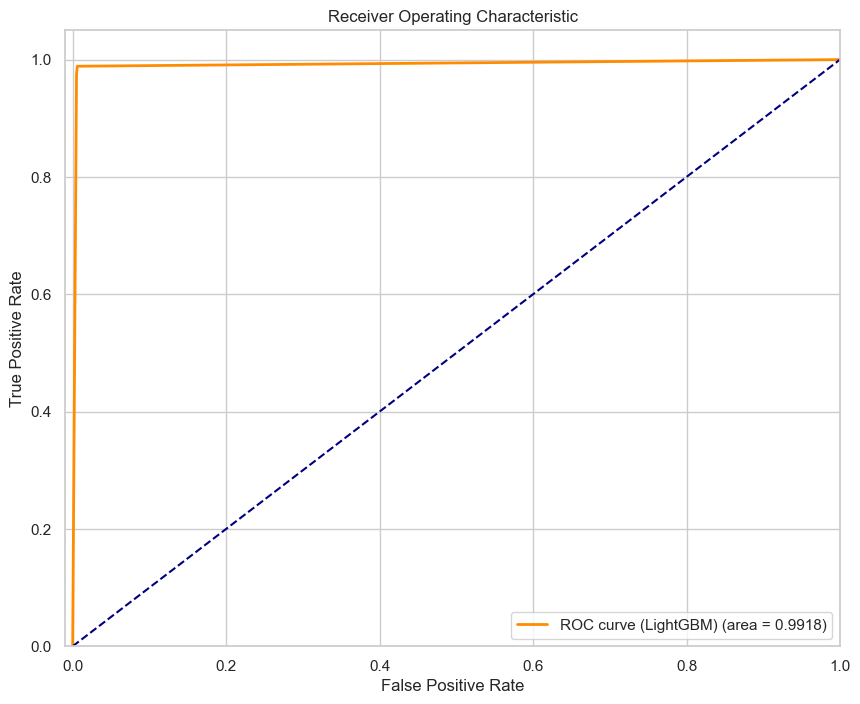

-----------------------------------
LightGBM - Seed: 49987
[LightGBM] [Info] Number of positive: 160711, number of negative: 323561
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029393 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4120
[LightGBM] [Info] Number of data points in the train set: 484272, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.331861 -> initscore=-0.699780
[LightGBM] [Info] Start training from score -0.699780


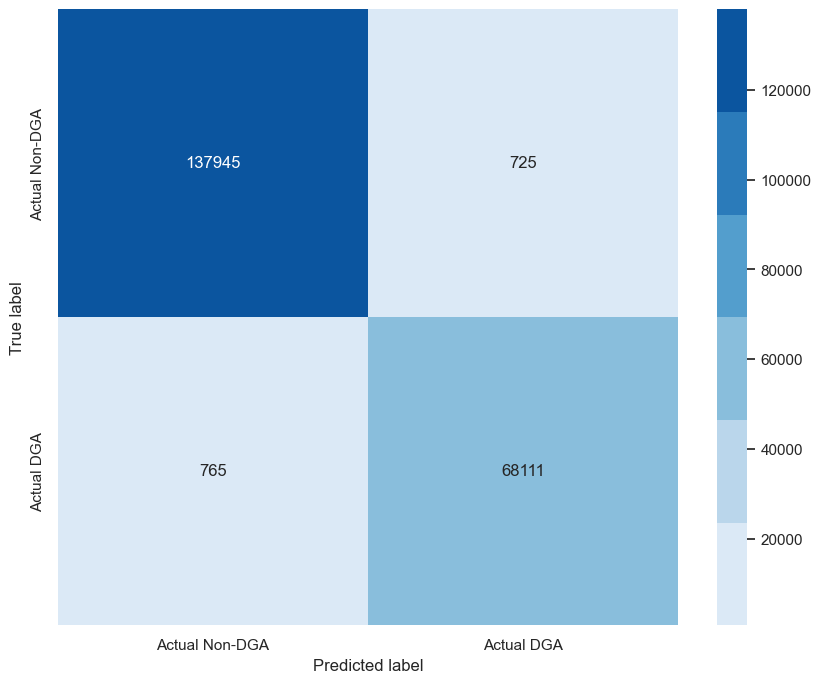

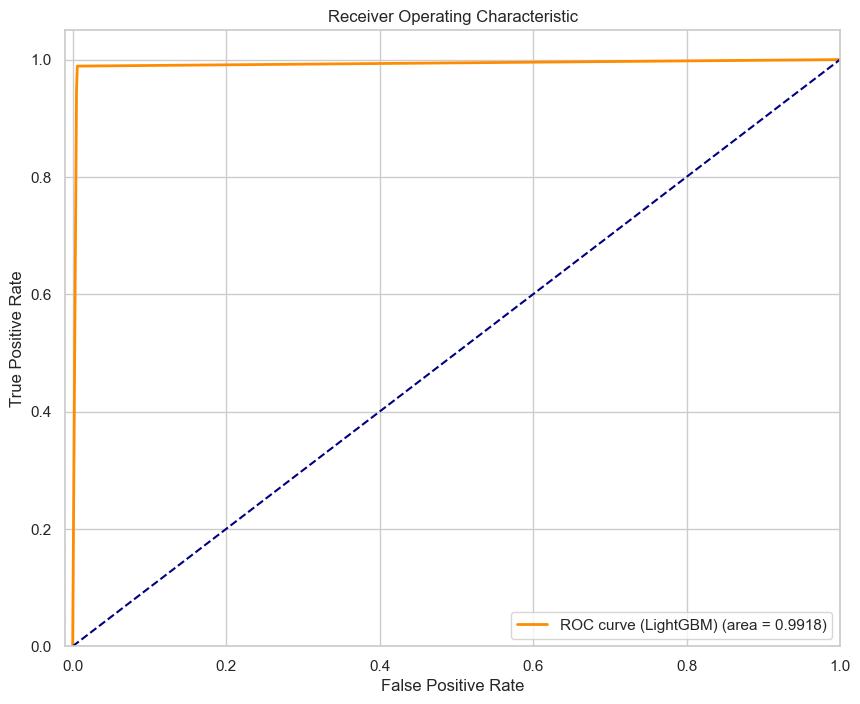

-----------------------------------
LightGBM - Seed: 58913
[LightGBM] [Info] Number of positive: 160711, number of negative: 323561
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.205591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4120
[LightGBM] [Info] Number of data points in the train set: 484272, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.331861 -> initscore=-0.699780
[LightGBM] [Info] Start training from score -0.699780


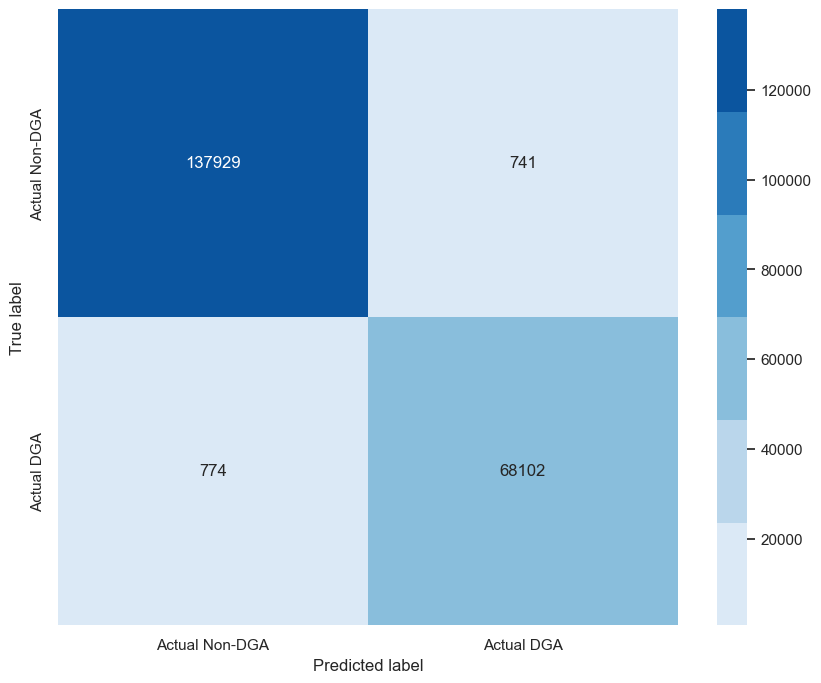

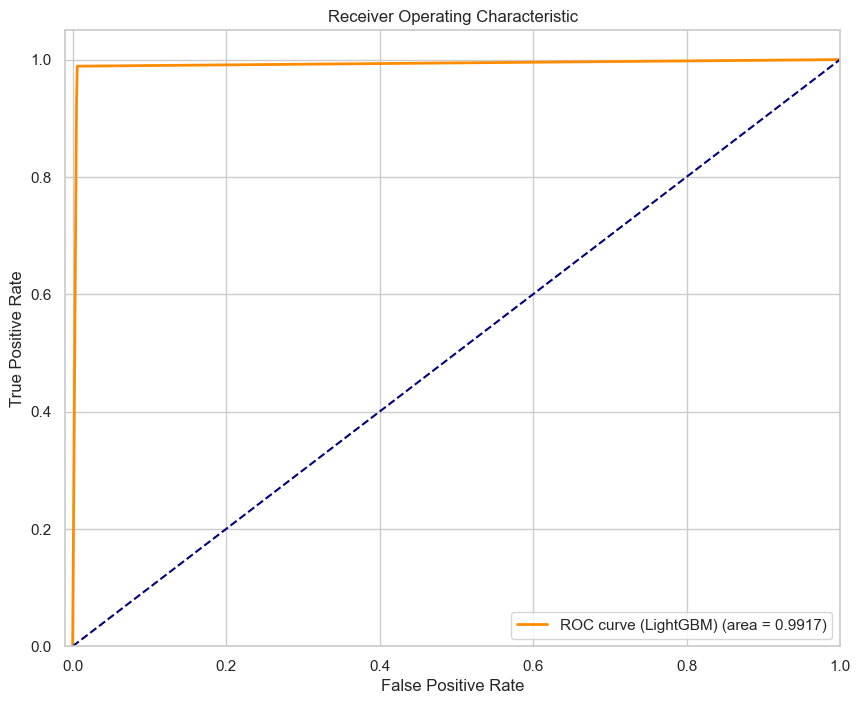

[51002, 28147, 27962, 49987, 58913]


,Accuracy,Precision,Recall,FPR,F1,AUC,Training time,Prediction time
0,0.992811,0.989439,0.988893,0.005243,0.989166,0.991825,30.986274,2.442747
1,0.992787,0.989452,0.988806,0.005235,0.989129,0.991785,22.200543,2.353253
2,0.992845,0.989767,0.988661,0.005077,0.989214,0.991792,23.626254,2.407796
3,0.992821,0.989468,0.988893,0.005228,0.989180,0.991832,27.605998,2.414282
4,0.992700,0.989236,0.988762,0.005344,0.988999,0.991709,30.626804,2.079291


In [25]:
import datetime

import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from lightgbm import LGBMClassifier
from sklearn.utils import shuffle

# Initialize results dictionary for LightGBM
results["LightGBM"] = {
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "FPR": [],
    "F1": [],
    "AUC": [],
    "Training time": [],
    "Prediction time": [],
}

# Define the parameters
params = {
    "objective": "binary",  # Specifies the task as binary classification
    "boosting_type": "gbdt",  # Uses Gradient Boosting Decision Tree algorithm
    # The minimum number of data points to be in a leaf node before a split can be performed
    "min_child_samples": 25,
    # Fraction of features (columns) to use at each iteration
    "colsample_bytree": 1,
    # Lambda parameter for L2 regularization to avoid overfitting by penalizing large values of the coefficients.
    "reg_lambda": 0.45,
    # Subsampling ratio of the training instances, used to speed up training and prevent overfitting
    "subsample": 0.85,
    # Frequency for subsampling, set to perform subsampling at every boosting iteration.
    "subsample_freq": 1,
    # Number of subsamples for constructing histogram bins for features, affects the speed of the algorithm.
    "subsample_for_bin": 200000,
    # The minimum loss reduction required to make a further partition on a leaf node
    "min_split_gain": 0.01,
    "n_estimators": 1050,  # Number of boosting rounds or trees to build
    "max_depth": 12,  # Maximum depth of each tree, used to control overfitting as higher depth will allow model to learn relations very specific to a particular sample
    # Maximum number of leaves per tree, a critical parameter to control model complexity
    "num_leaves": 30,
    # Shrinks the contribution of each tree by this factor, a lower rate requires more trees but can lead to better models
    "learning_rate": 0.075,
    # Balancing of positive and negative weights, useful for unbalanced class scenarios
    "scale_pos_weight": 1.5,
}

for seed in SEEDS:
    print("-----------------------------------")
    print(f"LightGBM - Seed: {seed}")

    # Shuffle
    lgbm_x_train, lgbm_y_train = shuffle(X_train, y_train, random_state=seed)

    # Create LightGBM model with specified parameters
    lgbm = LGBMClassifier(**params, random_state=seed, n_jobs=-1)

    # Measure the training time
    start_time = datetime.datetime.now()
    lgbm.fit(lgbm_x_train, lgbm_y_train)
    end_time = datetime.datetime.now()
    training_time = (end_time - start_time).total_seconds()

    # Measure the prediction time
    start_time = datetime.datetime.now()
    y_pred = lgbm.predict(X_test)
    end_time = datetime.datetime.now()
    prediction_time = (end_time - start_time).total_seconds()

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_sc = roc_auc_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fpr = fp / (fp + tn)

    # Store metrics in results dictionary
    results["LightGBM"]["Accuracy"].append(accuracy)
    results["LightGBM"]["Precision"].append(precision)
    results["LightGBM"]["Recall"].append(recall)
    results["LightGBM"]["F1"].append(f1)
    results["LightGBM"]["AUC"].append(auc_sc)
    results["LightGBM"]["FPR"].append(fpr)
    results["LightGBM"]["Training time"].append(training_time)
    results["LightGBM"]["Prediction time"].append(prediction_time)

    # Plot confusion matrix
    plot_confusion_matrix(y_test, y_pred, classes=["Actual Non-DGA", "Actual DGA"])

    # Plot ROC curve
    plot_roc_curve(y_test, y_pred, classifier_label="LightGBM")

print(SEEDS)
# Print the results in a dataframe - well-formatted table
results_df = pd.DataFrame(results["LightGBM"])
results_df

In [ ]:
results

{'LR': {'Accuracy': [0.983140655105973,
   0.983140655105973,
   0.983140655105973,
   0.983140655105973,
   0.983140655105973],
  'Precision': [0.9782293178519593,
   0.9782293178519593,
   0.9782293178519593,
   0.9782293178519593,
   0.9782293178519593],
  'Recall': [0.9711815561959655,
   0.9711815561959655,
   0.9711815561959655,
   0.9711815561959655,
   0.9711815561959655],
  'FPR': [0.01085383502170767,
   0.01085383502170767,
   0.01085383502170767,
   0.01085383502170767,
   0.01085383502170767],
  'F1': [0.9746926970354303,
   0.9746926970354303,
   0.9746926970354303,
   0.9746926970354303,
   0.9746926970354303],
  'AUC': [0.9801638605871289,
   0.9801638605871289,
   0.9801638605871289,
   0.9801638605871289,
   0.9801638605871289],
  'Training time': [5.08817, 4.302904, 2.876713, 5.525143, 2.965734],
  'Prediction time': [0.004473, 0.002223, 0.003442, 0.005129, 0.006378]},
 'SVM': {'Accuracy': [0.9889210019267822,
   0.9889210019267822,
   0.9889210019267822,
   0.988921

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import seaborn as sns
from sklearn.metrics import auc

def plot_zoomed_roc_curves(classifier_stats, zoom_fpr=(0.05, 0.15), zoom_tpr=(0.85, 1.00), title='Receiver Operating Characteristic'):
    """
    Plots a more detailed ROC curve around the knee, zoomed into a specified range.
    """
    plt.figure(figsize=(10, 8))
    sns.set(style="whitegrid")

    colors = {
        'LR': 'blue',
        'SVM': 'red',
        'DT': 'green',
        'RF': 'purple',
        'AdaBoost': 'orange',
        'XGBoost': 'cyan',
        'LightGBM': 'magenta'
    }

    mean_fpr = np.linspace(0, 1, 100)
    for classifier_label, metrics in classifier_stats.items():
        tprs = []
        aucs = []
        for i in range(len(metrics['FPR'])):
            fpr = np.array(metrics['FPR'][i])
            tpr = np.array(metrics['Recall'][i])
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
        
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0  # ensure it goes all the way to 1
        mean_auc = np.mean(aucs)
        std_auc = np.std(aucs)
        plt.plot(mean_fpr, mean_tpr, color=colors[classifier_label], label=r'%s (AUC = %0.2f $\pm$ %0.2f)' % (classifier_label, mean_auc, std_auc), lw=2, alpha=.8)

    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    plt.xlim(zoom_fpr)
    plt.ylim(zoom_tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()
    
plot_zoomed_roc_curves(results)

TypeError: Singleton array array(0.01085384) cannot be considered a valid collection.

<Figure size 1000x800 with 0 Axes>